# Análisis exploratorio (para el proyecto)

## Antes de partir...

### Requisitos

Usaremos los datos disponibles en [CONASET](https://mapas-conaset.opendata.arcgis.com/).

## Propuesta de proyecto

Esta podría ser una propuesta de proyecto inicial:

* **Situación**: La congestión y el tráfico en las ciudades es un fenómeno natural que emerge de las distintas actividades urbanas y su concentración espacial.
* **Complicación**: El transporte de personas también conlleva accidentes, con la correspondiente pérdida de vidas, problemas de salud y lesiones a las personas involucradas, daño a la propiedad pública y privada, y costo de tiempo a personas no involucradas.
* **Propuesta**: Caracterizar la accidentabilidad en Santiago para apoyar el diseño de políticas públicas que reduzcan la cantidad de accidentes.

Realizaremos un análisis exploratorio para ver su factibilidad e iterar  su definición.

## Bibliotecas necesarias

In [60]:
# para datos
import numpy as np
import pandas as pd
import geopandas as gpd
import requests
from pathlib import Path

# visualización en Python
import seaborn as sns
import matplotlib.pyplot as plt

from chiricoca.config import setup_style

setup_style()

## Construcción del dataset

Construir el dataset también involucra descargarlo y almacenarlo.

Lo descargamos [aquí](https://mapas-conaset.opendata.arcgis.com/search?categories=%252Fcategories%252Fregiones-%252Fregi%25C3%25B3n%2520metropolitana%2520de%2520santiago&groupIds=fca1f61c6556499db843c09cc80c70c0), o con el código que está más abajo ;)

In [61]:
data_path = Path("data") / "conaset"

if not data_path.exists():
    data_path.mkdir(parents=True)

In [62]:
urls = {
    '2019': 'https://hub.arcgis.com/api/v3/datasets/58cbd7c35ad14cfd955b1afa3a2b62fd_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1',
    '2020': 'https://hub.arcgis.com/api/v3/datasets/213520f62eb443dd9bdc3398c617a811_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1',
    '2021': 'https://hub.arcgis.com/api/v3/datasets/4b636b2f27164b0ebbeca0ab9db4d08a_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1',
    '2022': 'https://hub.arcgis.com/api/v3/datasets/88dd8179f726431da91f3ef4847a8dd2_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1',
    '2023': 'https://hub.arcgis.com/api/v3/datasets/30467ae1a8ef4708b64a4273b3672138_0/downloads/data?format=geojson&spatialRefId=4326&where=1%3D1',
}

files = {}

for year, url in urls.items():
    file_path = data_path / f"{year}-rm-car-accidents.json"
    files[year] = file_path
    if not file_path.exists():
        r = requests.get(url)
        with open(file_path, 'wt') as f:
            f.write(r.text)

In [63]:
gdf = {year: gpd.read_file(x, dtypes={'Fecha': 'str', 'Hora': 'str'}).to_crs('epsg:5361') for year, x in files.items()}
gdf

{'2019':          FID   Ano  Idaccident  Codregion                Region        Comuna  \
 0          1  2019     1167981         13  REGION METROPOLITANA   PUENTE ALTO   
 1          2  2019     1188851         13  REGION METROPOLITANA   PUENTE ALTO   
 2          3  2019     1193469         13  REGION METROPOLITANA   PUENTE ALTO   
 3          4  2019     1202470         13  REGION METROPOLITANA   PUENTE ALTO   
 4          5  2019     1210086         13  REGION METROPOLITANA   PUENTE ALTO   
 ...      ...   ...         ...        ...                   ...           ...   
 20663  20664  2019     1187234         13  REGION METROPOLITANA     QUILICURA   
 20664  20665  2019     1193547         13  REGION METROPOLITANA     QUILICURA   
 20665  20666  2019     1252457         13  REGION METROPOLITANA  LO BARNECHEA   
 20666  20667  2019     1171053         13  REGION METROPOLITANA  LO BARNECHEA   
 20667  20668  2019     1252979         13  REGION METROPOLITANA  LO BARNECHEA   
 
      

## Limpiado, Filtrado y Pre-Procesamiento

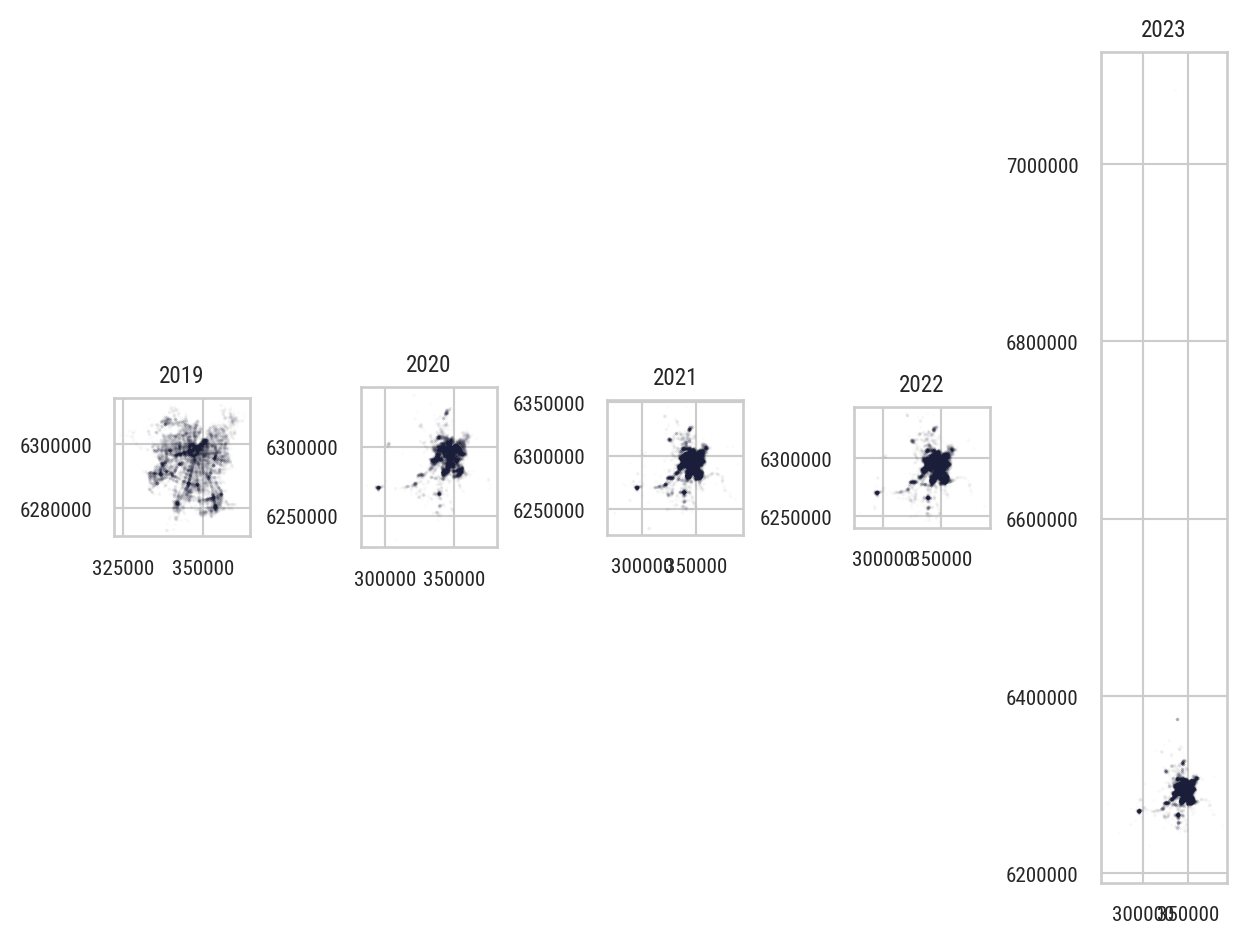

In [72]:
fig, axes = plt.subplots(1, 5)

for ax, year in zip(axes, files):
    gdf[year].plot(ax=ax, marker='.', markersize=1, alpha=0.01)
    ax.set_aspect('equal')
    ax.set_title(year)


In [86]:
#gdf['2019'].groupby('Fecha').size().plot()
#gdf['2019'].rolling(14, on='Fecha').mean()

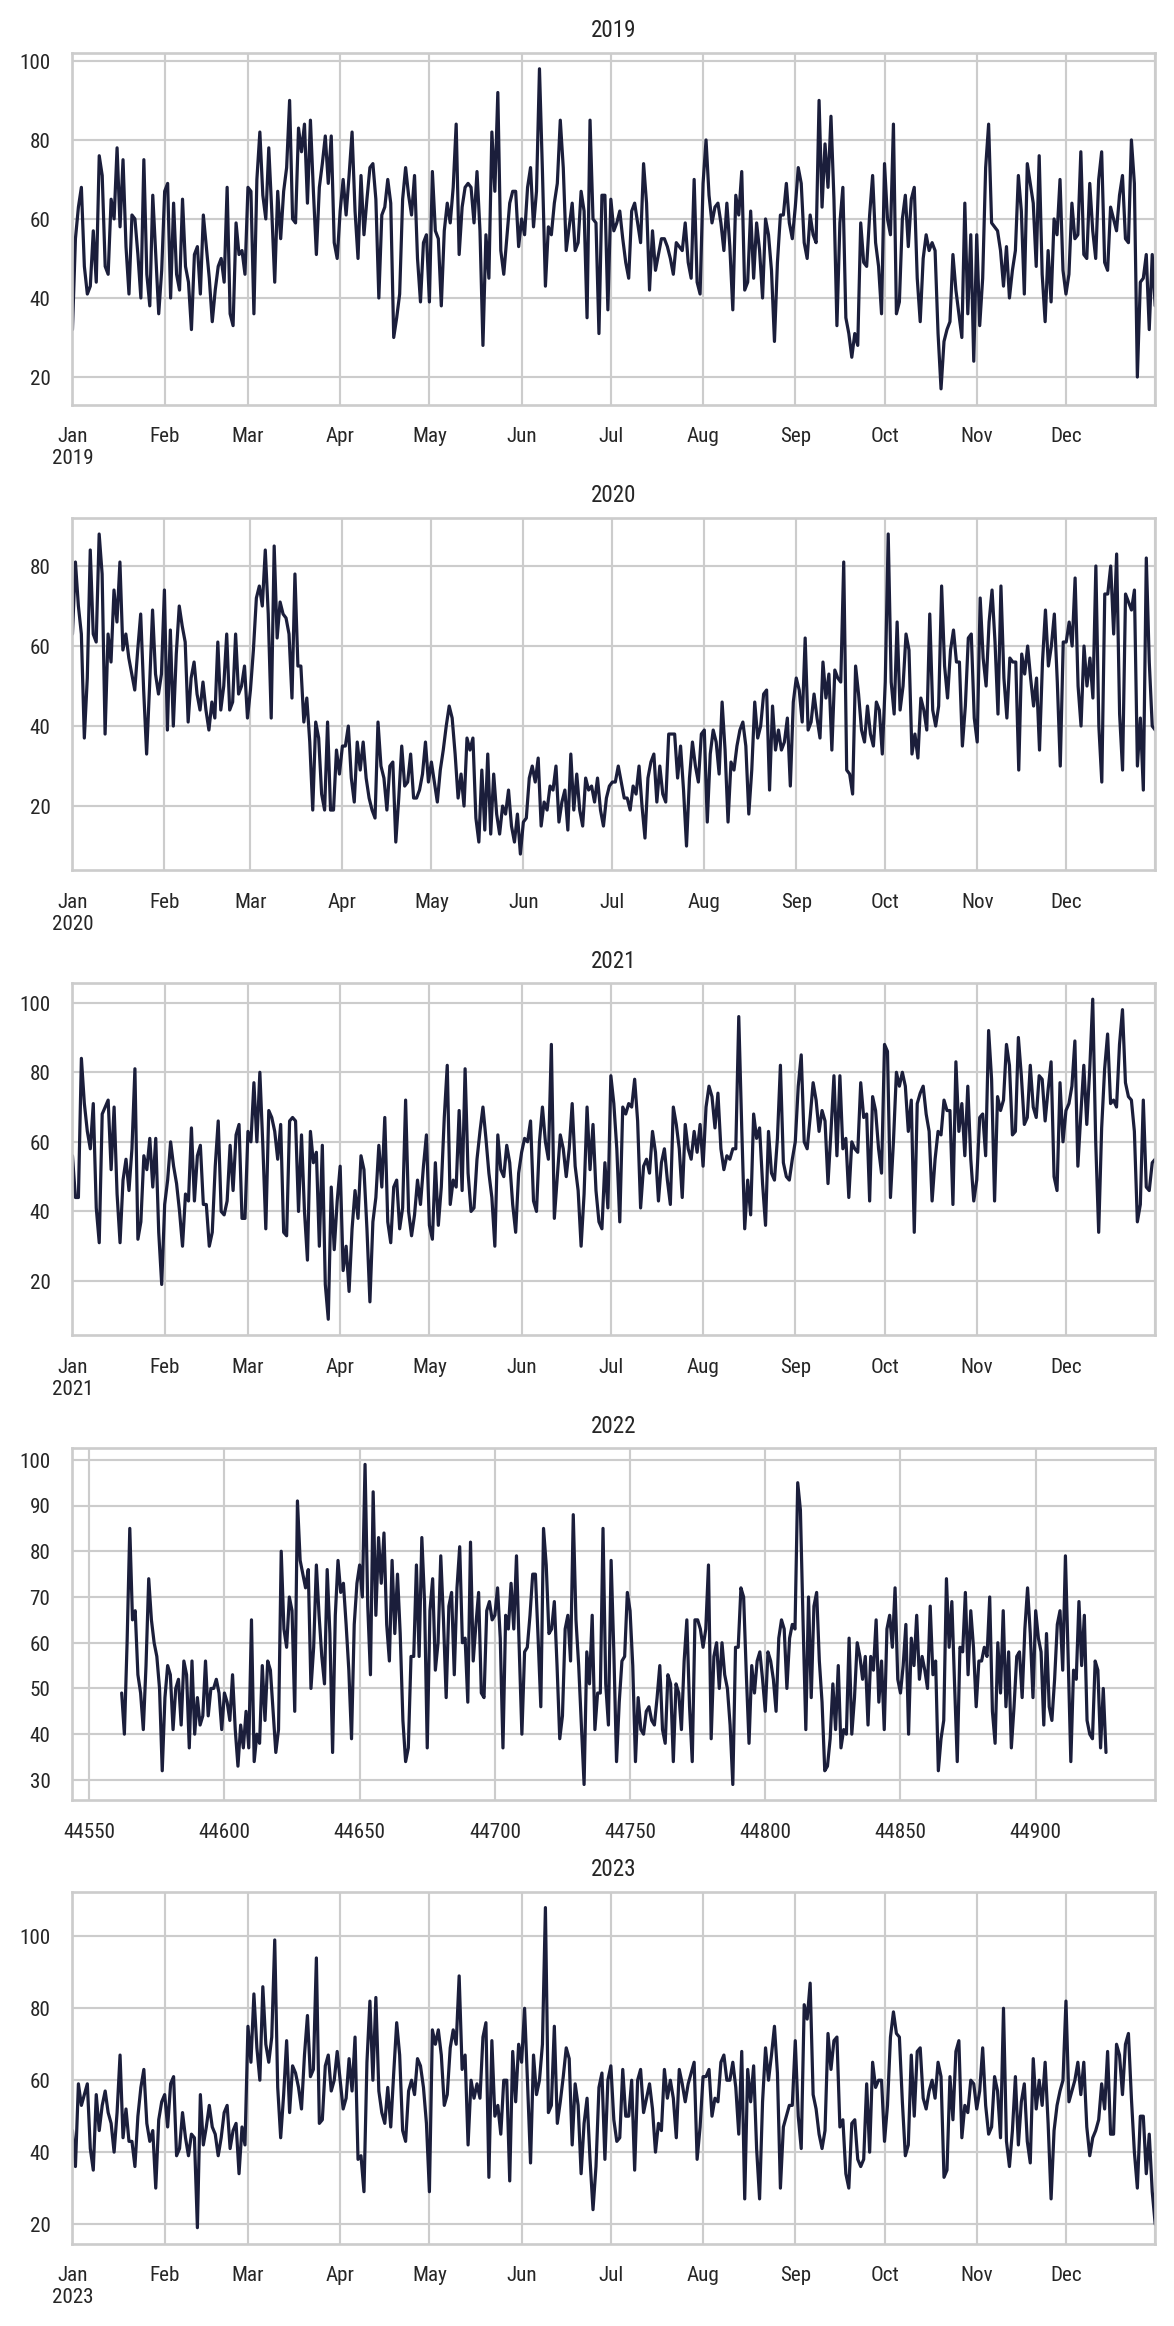

In [83]:
fig, axes = plt.subplots(5, 1, figsize=(6, 12))

for ax, year in zip(axes, files):
    try:
        gdf[year].groupby('Fecha').size().plot(ax=ax)
    except Exception as e:
        pass
    ax.set_title(year)
    ax.set_xlabel('')

In [87]:
gdf['2022'][['Fecha', 'Hora']]

Fecha      Hora
0      44586  19:10:00
1      44587  10:25:00
2      44590  08:32:00
3      44591  02:00:00
4      44592  13:30:00
...      ...       ...
20506  44907  07:00:00
20507  44911  07:40:00
20508  44911  12:15:00
20509  44923  17:55:00
20510  44921  14:30:00

[20511 rows x 2 columns]

In [90]:
gdf['2022']['Fecha'].describe()

count    20511.000000
mean     44742.005168
std        103.749600
min      44562.000000
25%      44654.000000
50%      44736.000000
75%      44833.000000
max      44926.000000
Name: Fecha, dtype: float64

In [91]:
gdf['2022']['Fecha'].max() - gdf['2022']['Fecha'].min()

364

In [92]:
gdf['2022']['Fecha'].head().map(lambda x: pd.Timedelta(x, unit='days')) + pd.to_datetime('1900-01-01')

0   2022-01-27
1   2022-01-28
2   2022-01-31
3   2022-02-01
4   2022-02-02
Name: Fecha, dtype: datetime64[ns]

In [93]:
gdf['2022']['Fecha_original'] = gdf['2022']['Fecha']

In [94]:
gdf["2022"]["Fecha"] = gdf["2022"]["Fecha_original"].map(
    lambda x: pd.Timedelta(x - 2, unit="days")
) + pd.to_datetime("1900-01-01", utc=True)
gdf['2022']['Fecha'].describe()

count                                  20511
mean     2022-06-30 00:07:26.511627776+00:00
min                2022-01-01 00:00:00+00:00
25%                2022-04-03 00:00:00+00:00
50%                2022-06-24 00:00:00+00:00
75%                2022-09-29 00:00:00+00:00
max                2022-12-31 00:00:00+00:00
Name: Fecha, dtype: object

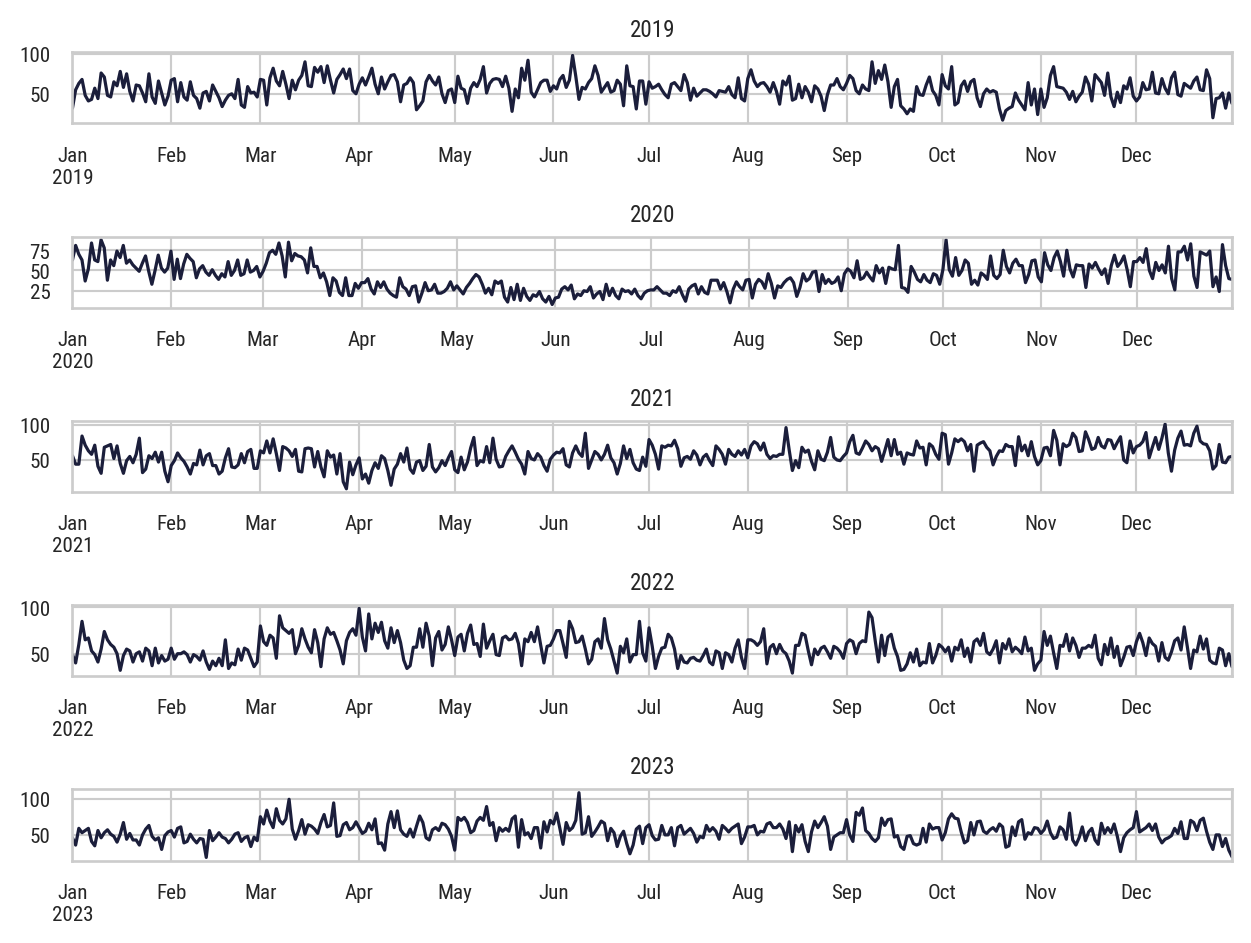

In [95]:
fig, axes = plt.subplots(5, 1)

for ax, year in zip(axes, files):
    try:
        gdf[year].groupby('Fecha').size().plot(ax=ax)
    except Exception as e:
        pass
    ax.set_title(year)
    ax.set_xlabel('')

In [96]:
for year, values in gdf.items():
    result = pd.isna(values).astype(int).describe().loc['mean']
    print(result)

FID           0.0
Ano           0.0
Idaccident    0.0
Codregion     0.0
Region        0.0
Comuna        0.0
Zona          0.0
Calle1        0.0
Calle2        0.0
Numero        0.0
lat           0.0
lng           0.0
Claseaccid    0.0
Fecha         0.0
Cód_Comun     0.0
Cód_Tipo_     0.0
Tipo_Accid    0.0
Cód_Tipo1     0.0
Tipo__CONA    0.0
Cód_Zona      0.0
Zona_1        0.0
Cód_Ubica     0.0
Ubicación     0.0
Cód_Causa     0.0
Causa__CON    0.0
Cód_Cau_1     0.0
Causa         0.0
Cód_Calle     0.0
Intersecci    0.0
Pistas_de_    0.0
Pistas_de1    0.0
Cód_Calza     0.0
Calzada       0.0
Cód__Tipo     0.0
Tipo_Calza    0.0
Cód_Estad     0.0
Estado_Cal    0.0
Cód_Condi     0.0
Condición     0.0
Cód_Est_1     0.0
Estado_Atm    0.0
Fallecidos    0.0
Graves        0.0
Menos_Grav    0.0
Leves         0.0
Hora          0.0
geometry      0.0
Name: mean, dtype: float64
FID           0.0
DIR_GEOCOD    0.0
LAT           0.0
LNG           0.0
VAL_COM       0.0
Hora          0.0
Año           0.0
I

In [97]:
accidents = pd.concat(gdf.values())

<Axes: xlabel='Fecha'>

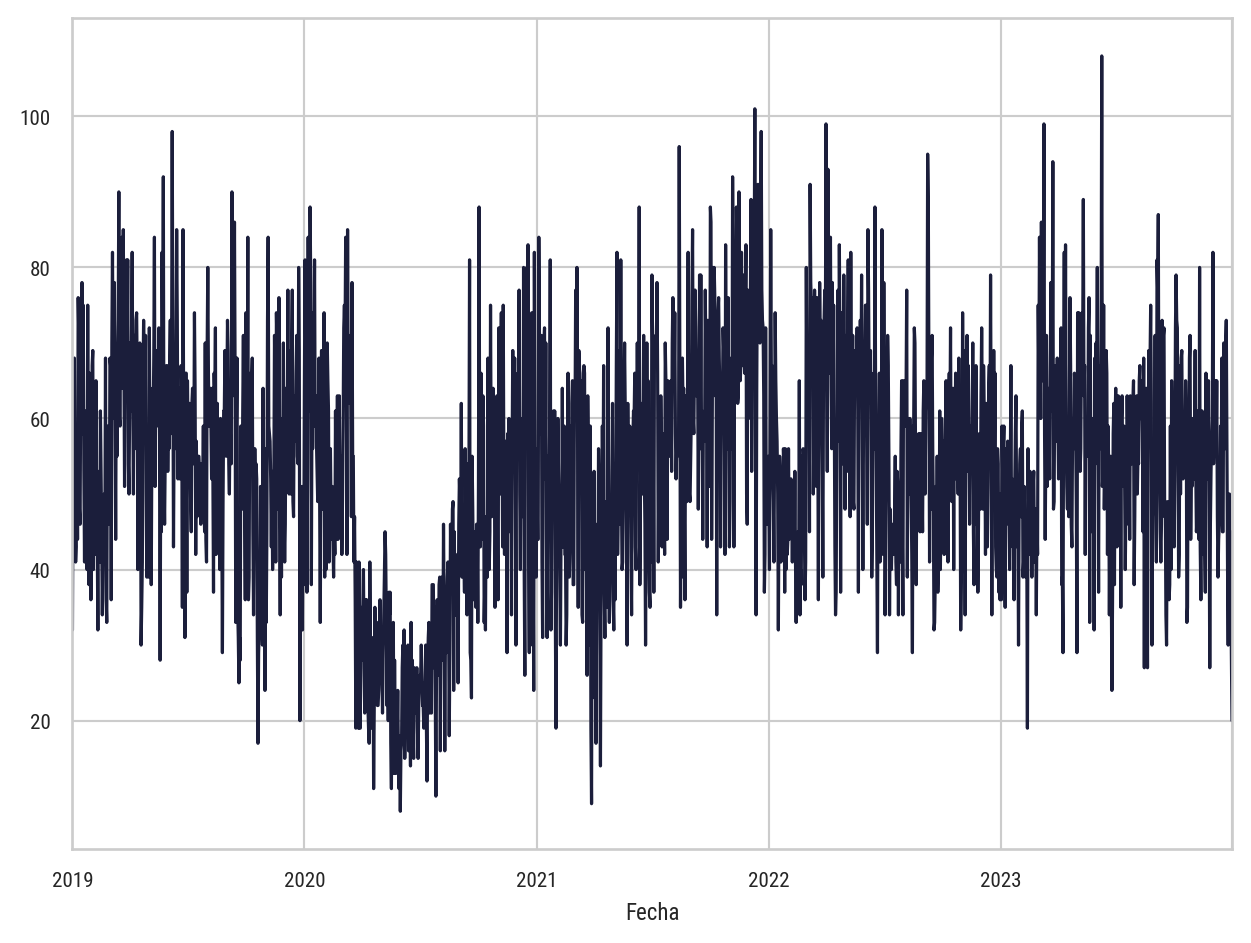

In [98]:
accidents.groupby('Fecha').size().plot()

<Axes: >

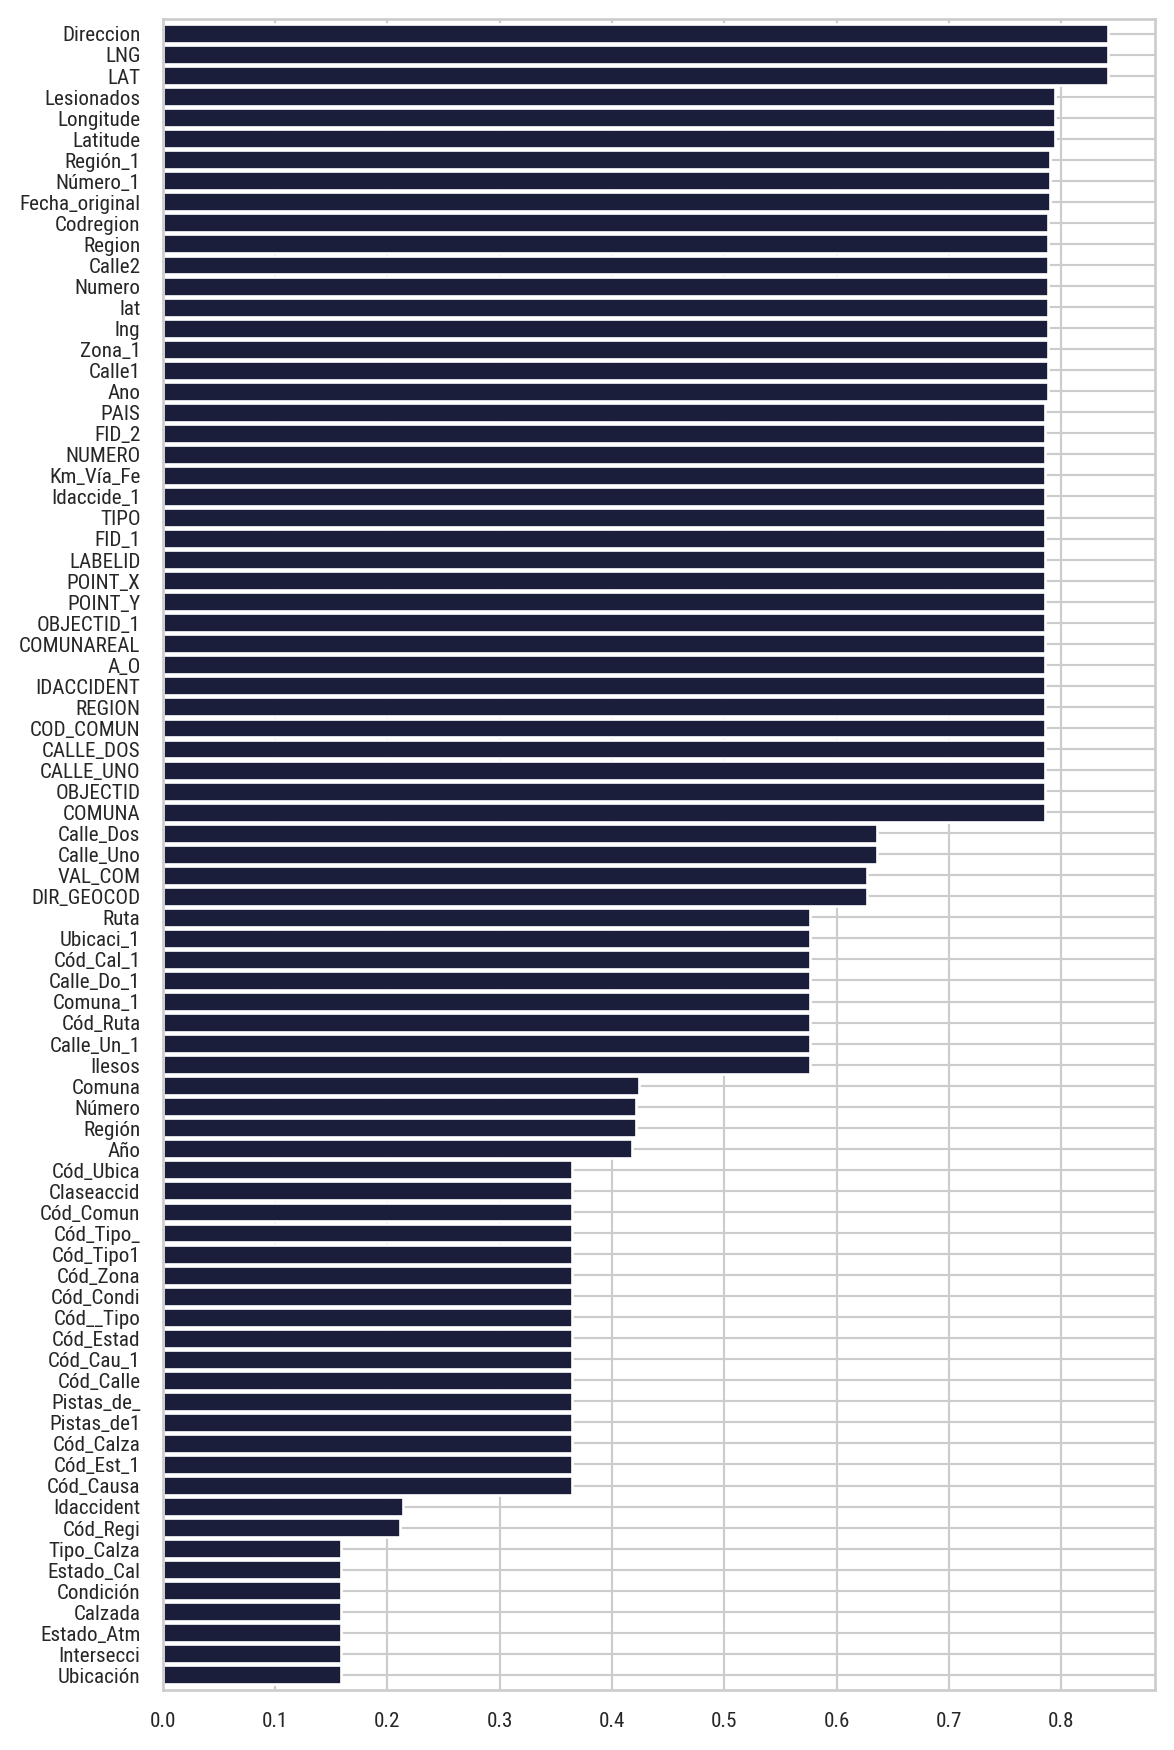

In [102]:
null_test = pd.isna(accidents).astype(int).describe().loc['mean']
fig, ax = plt.subplots(figsize=(6, 9))
null_test[null_test > 0].sort_values().plot(kind='barh', linewidth=1, width=0.9)

In [110]:
accidents.filter(like='Cau').sample(10)

Cód_Causa                    Causa__CON  Cód_Cau_1  \
1960         NaN     IMPRUDENCIA DEL CONDUCTOR        NaN   
17122       93.0     IMPRUDENCIA DEL CONDUCTOR        1.0   
13705        NaN     IMPRUDENCIA DEL CONDUCTOR        NaN   
1511        10.0  DESOBEDIENCIA A SEÑALIZACION       62.0   
6114         NaN  DESOBEDIENCIA A SEÑALIZACION        NaN   
14392        NaN     IMPRUDENCIA DEL CONDUCTOR        NaN   
7934         NaN          ALCOHOL EN CONDUCTOR        NaN   
5022         NaN  DESOBEDIENCIA A SEÑALIZACION        NaN   
4073        62.0  DESOBEDIENCIA A SEÑALIZACION       10.0   
15323       27.0     IMPRUDENCIA DEL CONDUCTOR        1.0   

                                                   Causa  
1960   CONDUCCION NO ATENTO CONDICIONES TRANSITO MOMENTO  
17122                     CONDUCIR VEHICULO EN RETROCESO  
13705  CONDUCCION NO ATENTO CONDICIONES TRANSITO MOMENTO  
1511       SEÑALIZACION DESOBEDECER LUZ ROJA DE SEMAFORO  
6114       SEÑALIZACION DESOBEDECER LUZ ROJA DE SEMAFORO  
14392  CONDUCCION NO ATENTO CONDICIONES TRANSITO MOMENTO  
7934                    CONDUCCION EN ESTADO DE EBRIEDAD  
5022       SEÑALIZACION DESOBEDECER LUZ ROJA DE SEMAFORO  
4073       SEÑALIZACION DESOBEDECER LUZ ROJA DE SEMAFORO  
15323  CONDUCCION NO ATENTO CONDICIONES TRANSITO MOMENTO

In [113]:
len(accidents)

97673

In [111]:
accidents['Causa'].describe()

count                                                 97673
unique                                                   60
top       CONDUCCION NO ATENTO CONDICIONES TRANSITO MOMENTO
freq                                                  36986
Name: Causa, dtype: object

In [112]:
accidents['Causa__CON'].describe()

count                         97673
unique                           14
top       IMPRUDENCIA DEL CONDUCTOR
freq                          59568
Name: Causa__CON, dtype: object

In [119]:
accidents.filter(like='Ubi').sample(10)

Cód_Ubica                       Ubicación Ubicaci_1
1270        15.0    CRUCE CON SEÑAL CEDA EL PASO          
4814         1.0              TRAMO DE VIA RECTA       NaN
16912       11.0  CRUCE CON SEMAFORO FUNCIONANDO          
6816         1.0              TRAMO DE VIA RECTA          
20606        1.0              TRAMO DE VIA RECTA          
4567        11.0  CRUCE CON SEMAFORO FUNCIONANDO       NaN
5233        14.0            CRUCE CON SEÑAL PARE          
5870        11.0  CRUCE CON SEMAFORO FUNCIONANDO          
7793         NaN                             NaN       NaN
16269       15.0    CRUCE CON SEÑAL CEDA EL PASO       NaN

In [120]:
accidents['Ubicación'].describe()

count                  82188
unique                    19
top       TRAMO DE VIA RECTA
freq                   38535
Name: Ubicación, dtype: object

In [122]:
accidents.filter(like='TIPO').sample(10)

TIPO
17311                 NaN
9161                  NaN
15815                 NaN
2683     GEOMETRIC_CENTER
3005                  NaN
6427                  NaN
868                   NaN
14325    GEOMETRIC_CENTER
8909   RANGE_INTERPOLATED
13015                 NaN

In [125]:
accidents.filter(like='Tip').sample(10)

Cód_Tipo_               Tipo_Accid  Cód_Tipo1 Tipo__CONA  Cód__Tipo  \
5552         NaN         CHOQUE POSTERIOR        NaN     CHOQUE        NaN   
7393         NaN   COLISION PERPENDICULAR        NaN   COLISION        NaN   
7116        30.0                 COLISION       30.0   COLISION        2.0   
3811         NaN     COLISION POR ALCANCE        NaN   COLISION        NaN   
20011       30.0                 COLISION       30.0   COLISION        2.0   
16559       33.0     COLISION POR ALCANCE       30.0   COLISION        2.0   
10815       30.0                 COLISION       30.0   COLISION        2.0   
4899        63.0  CHOQUE FRENTE/POSTERIOR       40.0     CHOQUE        1.0   
18084       32.0         COLISION LATERAL       30.0   COLISION        2.0   
6374         NaN     COLISION POR ALCANCE        NaN   COLISION        NaN   

      Tipo_Calza  
5552     ASFALTO  
7393     ASFALTO  
7116     ASFALTO  
3811    CONCRETO  
20011    ASFALTO  
16559    ASFALTO  
10815    ASFALTO  
4899    CONCRETO  
18084    ASFALTO  
6374     ASFALTO

In [126]:
accidents['Tipo__CONA'].describe()

count        97673
unique           7
top       COLISION
freq         63646
Name: Tipo__CONA, dtype: object

In [127]:
accidents['Tipo_Accid'].describe()

count                97673
unique                  24
top       COLISION LATERAL
freq                 26136
Name: Tipo_Accid, dtype: object

In [128]:
accidents.columns

Index(['FID', 'Ano', 'Idaccident', 'Codregion', 'Region', 'Comuna', 'Zona',
       'Calle1', 'Calle2', 'Numero', 'lat', 'lng', 'Claseaccid', 'Fecha',
       'Cód_Comun', 'Cód_Tipo_', 'Tipo_Accid', 'Cód_Tipo1', 'Tipo__CONA',
       'Cód_Zona', 'Zona_1', 'Cód_Ubica', 'Ubicación', 'Cód_Causa',
       'Causa__CON', 'Cód_Cau_1', 'Causa', 'Cód_Calle', 'Intersecci',
       'Pistas_de_', 'Pistas_de1', 'Cód_Calza', 'Calzada', 'Cód__Tipo',
       'Tipo_Calza', 'Cód_Estad', 'Estado_Cal', 'Cód_Condi', 'Condición',
       'Cód_Est_1', 'Estado_Atm', 'Fallecidos', 'Graves', 'Menos_Grav',
       'Leves', 'Hora', 'geometry', 'DIR_GEOCOD', 'LAT', 'LNG', 'VAL_COM',
       'Año', 'Cód_Regi', 'Región', 'Calle_Uno', 'Calle_Dos', 'Número',
       'Direccion', 'FID_1', 'LABELID', 'POINT_X', 'POINT_Y', 'FID_2',
       'COMUNAREAL', 'OBJECTID', 'A_O', 'IDACCIDENT', 'REGION', 'COD_COMUN',
       'COMUNA', 'CALLE_UNO', 'CALLE_DOS', 'NUMERO', 'PAIS', 'TIPO',
       'OBJECTID_1', 'Idaccide_1', 'Comuna_1', 'Calle_Un

In [129]:
len(accidents)
for values in gdf.values():
    print(len(values))

20668
15485
20915
20511
20094


<Axes: >

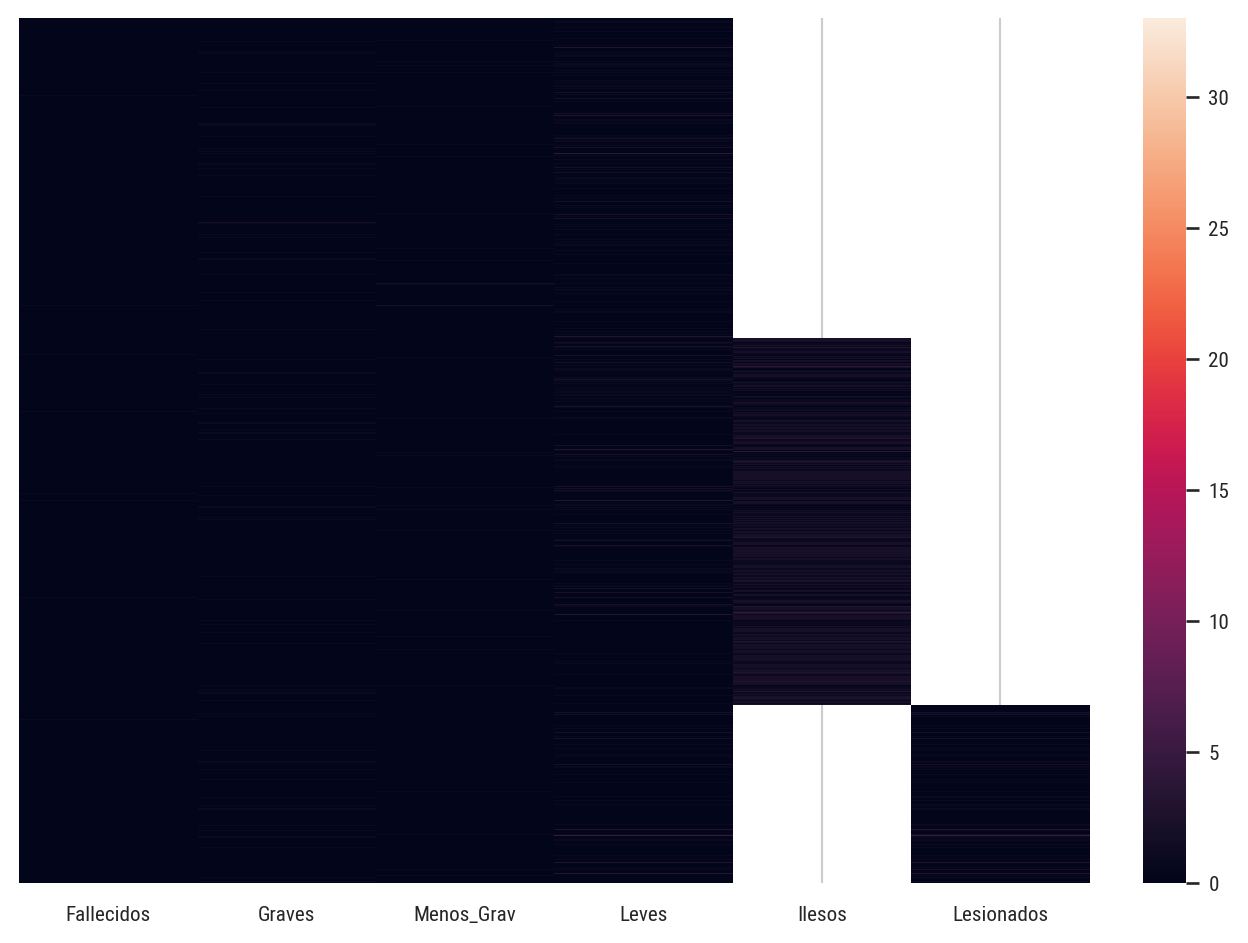

In [130]:
fig, ax = plt.subplots()

sns.heatmap(
    accidents[["Fallecidos", "Graves", "Menos_Grav", "Leves", "Ilesos", "Lesionados"]],
    ax=ax,
    yticklabels=False,
)

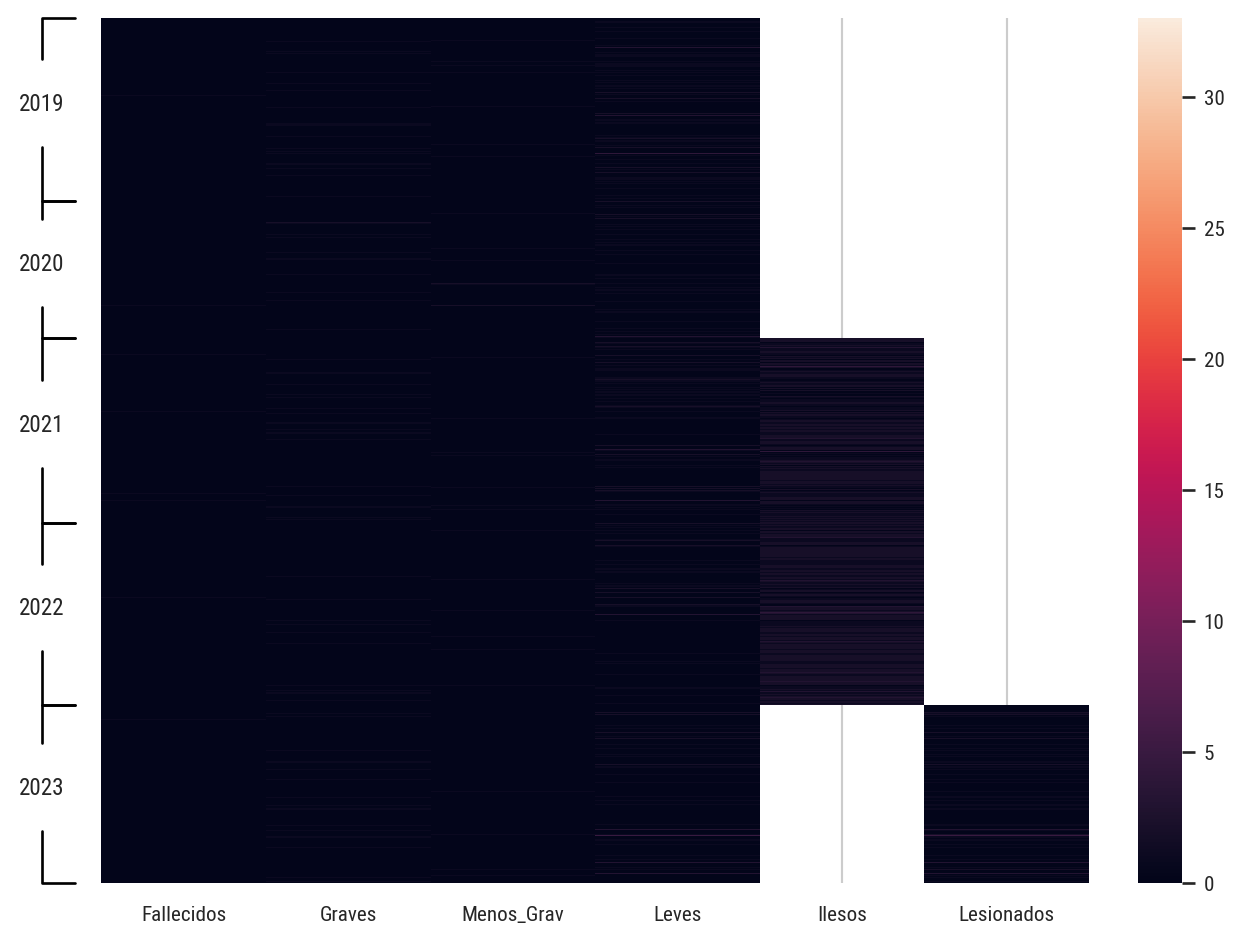

In [131]:
fig, ax = plt.subplots()

sns.heatmap(
    accidents[["Fallecidos", "Graves", "Menos_Grav", "Leves", "Ilesos", "Lesionados"]],
    ax=ax,
    yticklabels=False,
)

ymin = 0
props = dict(
    connectionstyle="angle, angleA=90, angleB=180, rad=0",
    arrowstyle="-",
    shrinkA=10,
    shrinkB=10,
    color="black",
    lw=1,
)

for year, values in gdf.items():
    ymax = ymin + len(values)
    x = 0
    dy = len(values)
    dx = -0.5

    ax.annotate(
        year,
        xy=(x, ymin),
        xytext=(x + dx, ymin + dy / 2),
        annotation_clip=False,
        arrowprops=props,
    )
    ax.annotate(
        year,
        xy=(x, ymax),
        xytext=(x + dx, ymin + dy / 2),
        annotation_clip=False,
        alpha=0,
        arrowprops=props,
    )

    ymin = ymax
    # break

<Axes: >

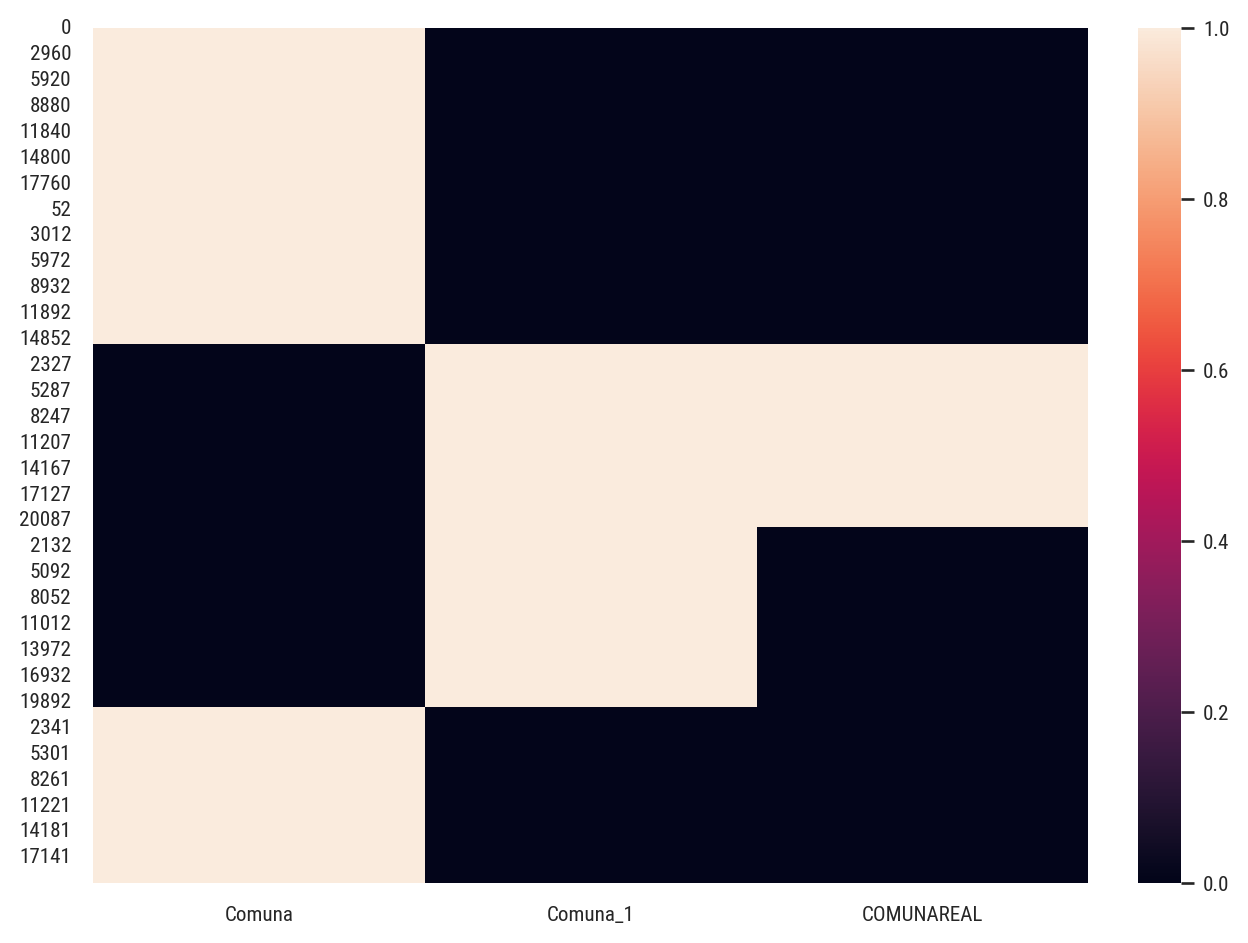

In [132]:
sns.heatmap(pd.notnull(accidents[['Comuna', 'Comuna_1', 'COMUNAREAL']]))

In [133]:
accidents['comuna'] = accidents['Comuna']
accidents.loc[pd.isnull(accidents['comuna']),'comuna'] = accidents['COMUNAREAL'][pd.isnull(accidents['comuna'])]
accidents.loc[pd.isnull(accidents['comuna']),'comuna'] = accidents['Comuna_1'][pd.isnull(accidents['comuna'])]
accidents['comuna'].describe()

count        97673
unique          58
top       SANTIAGO
freq          8321
Name: comuna, dtype: object

## Filtrar

En http://bboxfinder.com podemos definir una _caja contenedora_ (_bounding box_) para área de análisis.\
CRS = Coordinate Reference System

In [134]:
from chiricoca.geo.utils import clip_point_geodataframe

In [135]:
scl_bounds = [-70.88006218, -33.67612715, -70.43015094, -33.31069169]

<Axes: >

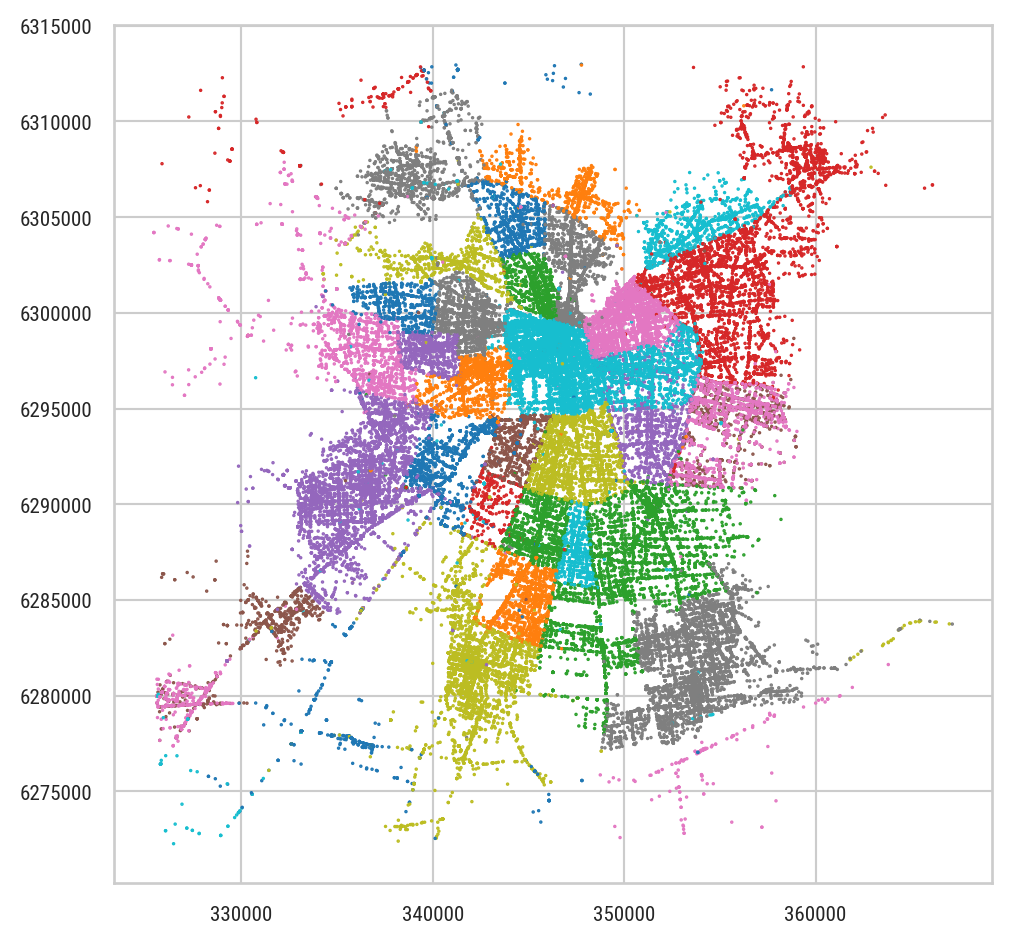

In [136]:
scl = clip_point_geodataframe(accidents.to_crs('epsg:4326'), scl_bounds).to_crs(accidents.crs)
scl.plot(marker='.', markersize=1, column='comuna')

In [137]:
scl['month'] = scl['Fecha'].dt.month
scl['year'] = scl['Fecha'].dt.year
scl['day_of_week'] = scl['Fecha'].dt.dayofweek

In [138]:
len(scl)

91104

## ¿Qué contiene?

<Axes: ylabel='Tipo_Accid'>

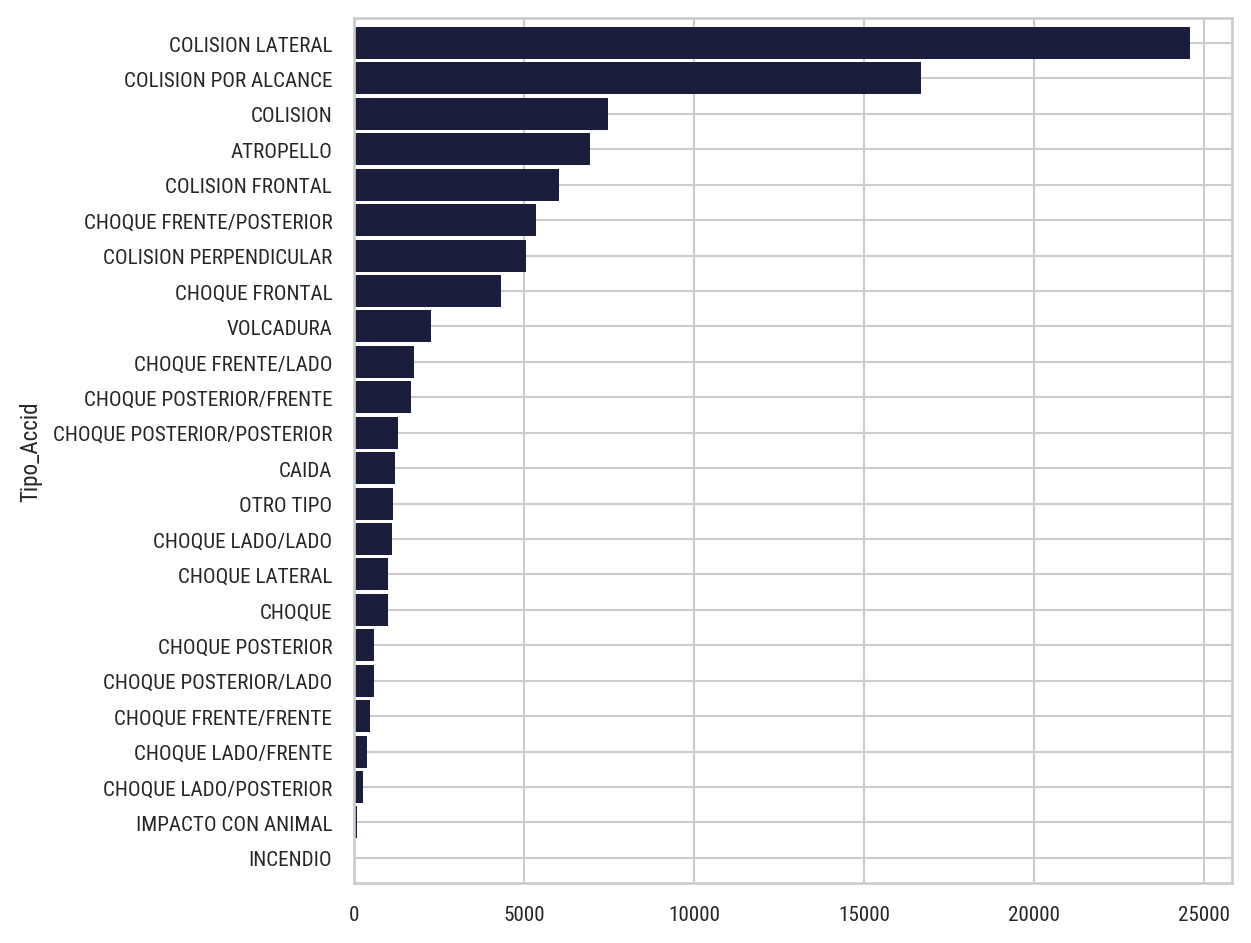

In [140]:
scl["Tipo_Accid"].value_counts().sort_values(ascending=True).plot(
    kind="barh", linewidth=0, width=0.9
)

<Axes: ylabel='Causa'>

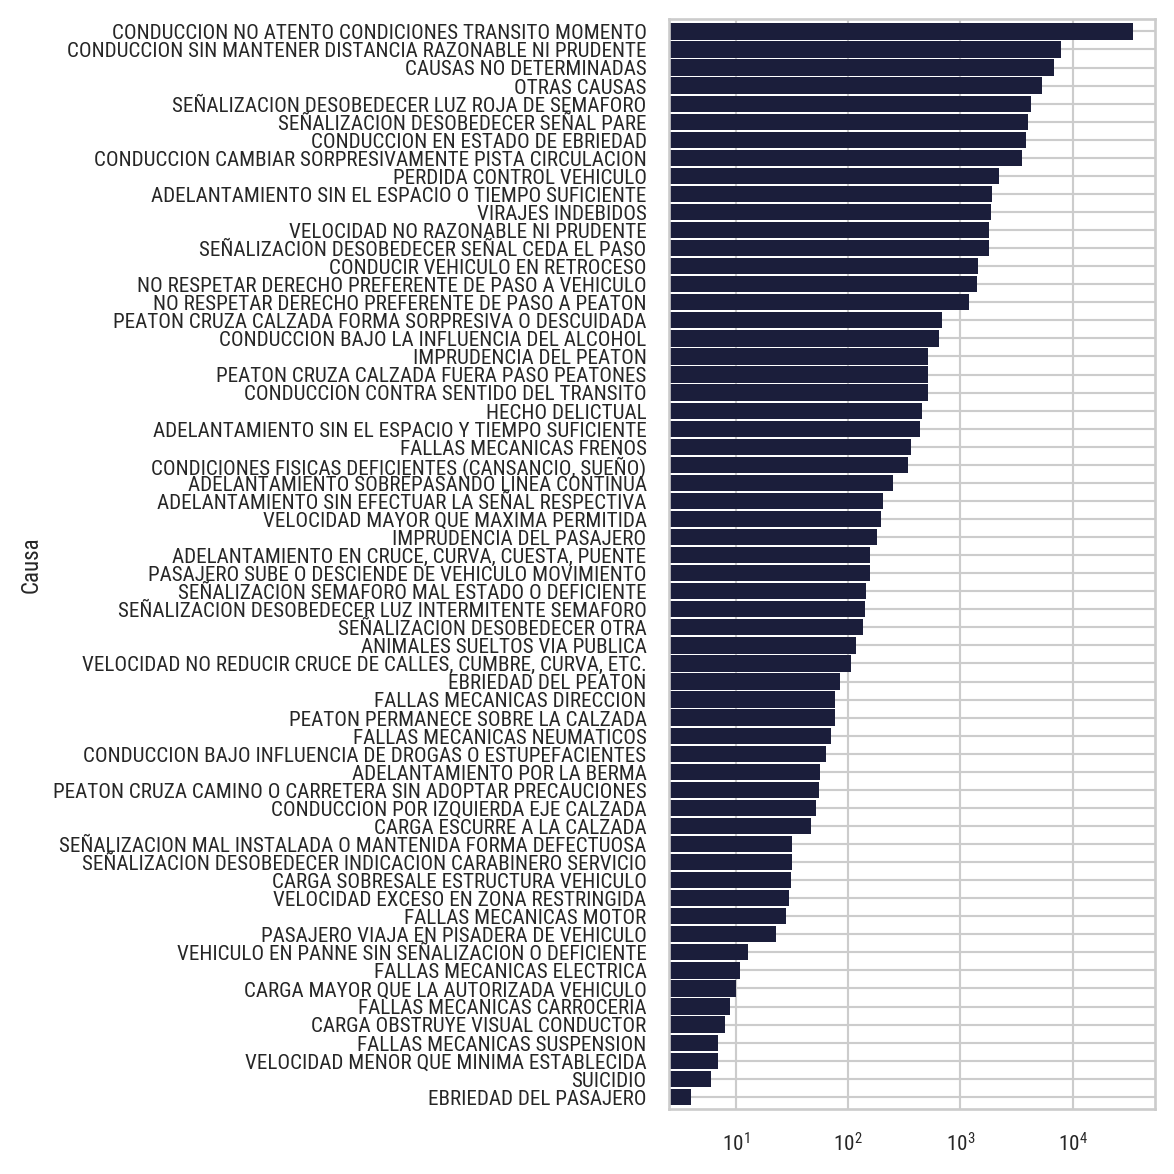

In [146]:
fig, ax = plt.subplots(figsize=(6,6))

scl["Causa"].value_counts().sort_values(ascending=True).plot(
    kind="barh", linewidth=0, width=0.9, ax=ax, logx=True
)

<Axes: ylabel='Causa__CON'>

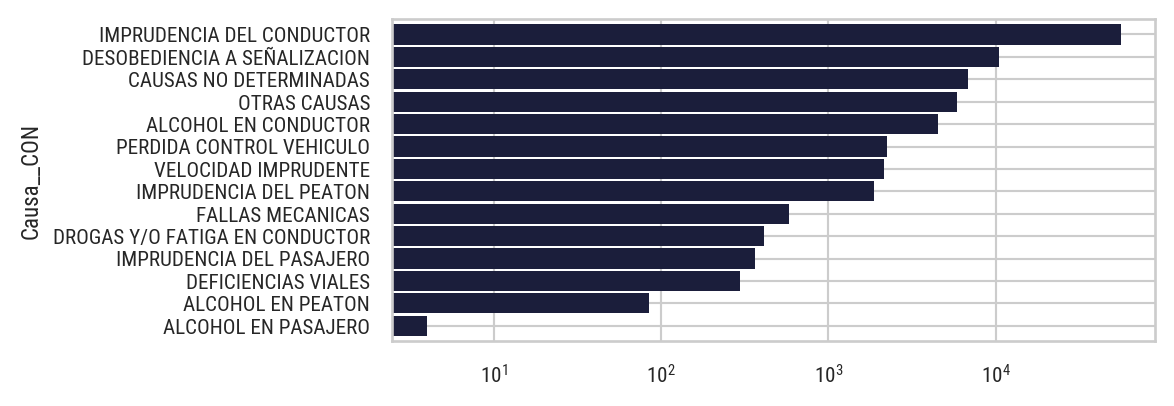

In [149]:
fig, ax = plt.subplots(figsize=(6,2))

scl["Causa__CON"].value_counts().sort_values(ascending=True).plot(
    kind="barh", linewidth=0, width=0.9, ax=ax, logx=True
)

In [152]:
victimas = scl[["Fallecidos", "Graves", "Menos_Grav", "Leves"]].assign(
    total=lambda x: x.sum(axis=1)
).groupby("total").sum().drop(0)

victimas

Fallecidos  Graves  Menos_Grav  Leves
total                                       
1             748    5957        2043  16945
2             215    1420         599   7648
3              70     370         188   2288
4              20     153          79   1048
5              14      48          22    456
6               3      20          10    207
7              11      24           8     97
8               4       6           5     73
9               0       2           3     13
10              5       0           8     17
12              0       0           0     12
13              2      11           0     13
14              2       4           1      7
15              0       0           7      8
16              0       4           0     28
18              0       7           1     10
20              0       1           0     19
22              3       0           0     19
28              0       0           0     28
33              0       2           0     31

<Axes: xlabel='total'>

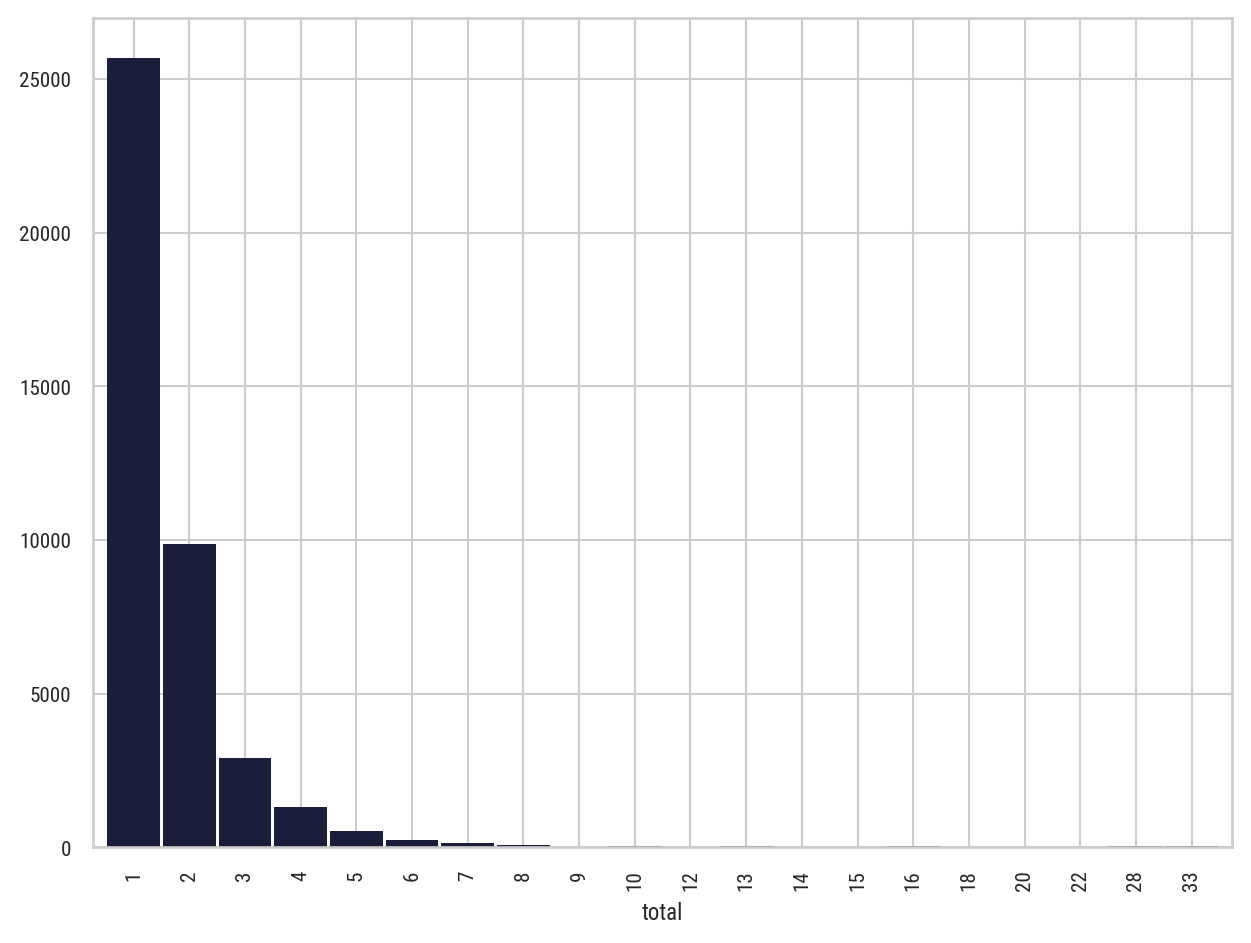

In [158]:
victimas.sum(axis=1).plot(kind='bar', width=0.95, linewidth=0)

<Axes: xlabel='total'>

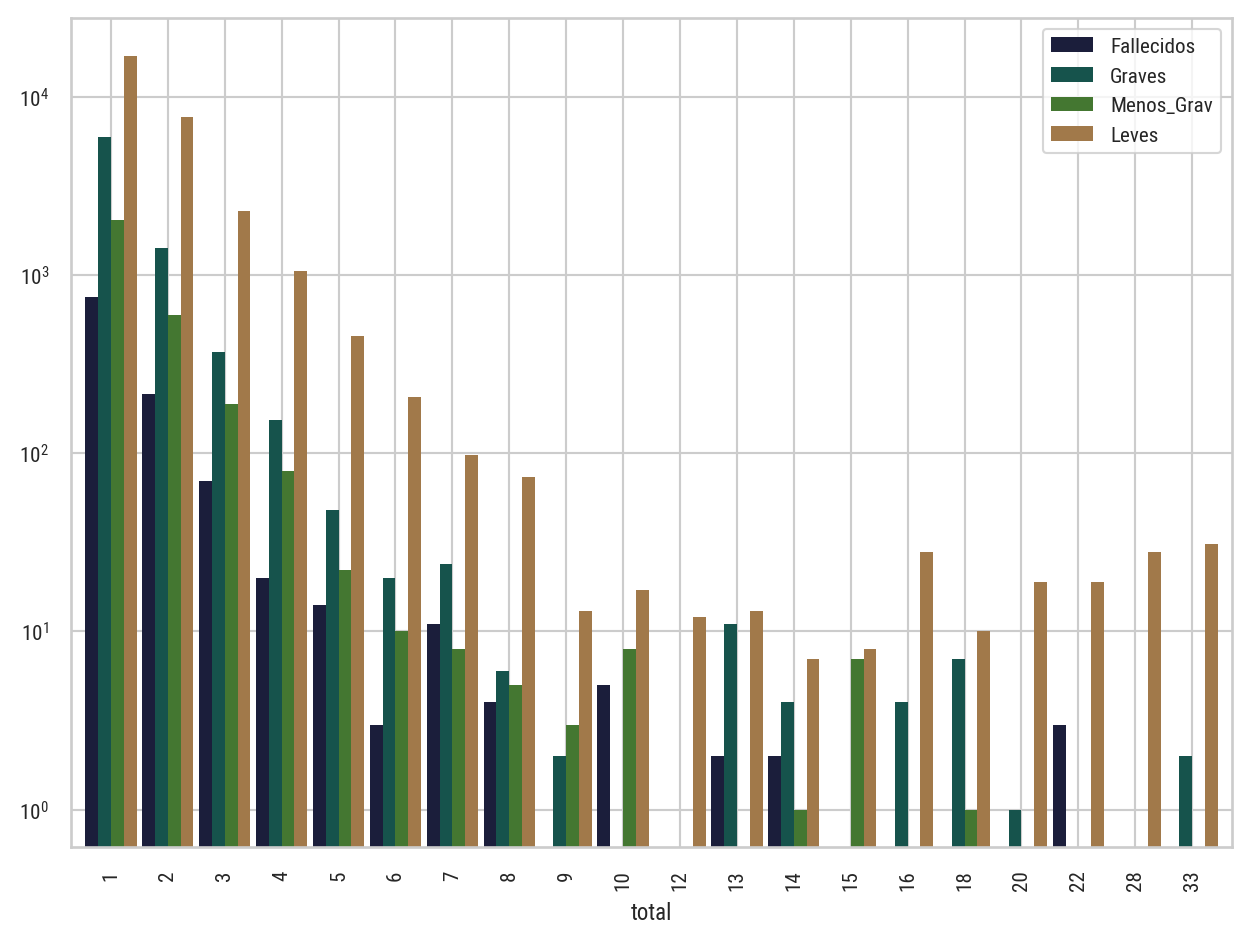

In [162]:
victimas.plot(
    kind="bar", logy=True, linewidth=0, width=0.9
)

In [164]:
from chiricoca.base.weights import normalize_rows
victimas.pipe(normalize_rows)

Fallecidos     Graves  Menos_Grav       Leves
total                                               
1        2.911299  23.185303    7.951582   65.951816
2        2.175673  14.369561    6.061526   77.393240
3        2.400549  12.688615    6.447188   78.463649
4        1.538462  11.769231    6.076923   80.615385
5        2.592593   8.888889    4.074074   84.444444
6        1.250000   8.333333    4.166667   86.250000
7        7.857143  17.142857    5.714286   69.285714
8        4.545455   6.818182    5.681818   82.954545
9        0.000000  11.111111   16.666667   72.222222
10      16.666667   0.000000   26.666667   56.666667
12       0.000000   0.000000    0.000000  100.000000
13       7.692308  42.307692    0.000000   50.000000
14      14.285714  28.571429    7.142857   50.000000
15       0.000000   0.000000   46.666667   53.333333
16       0.000000  12.500000    0.000000   87.500000
18       0.000000  38.888889    5.555556   55.555556
20       0.000000   5.000000    0.000000   95.000000
22      13.636364   0.000000    0.000000   86.363636
28       0.000000   0.000000    0.000000  100.000000
33       0.000000   6.060606    0.000000   93.939394

(0.0, 1.0)

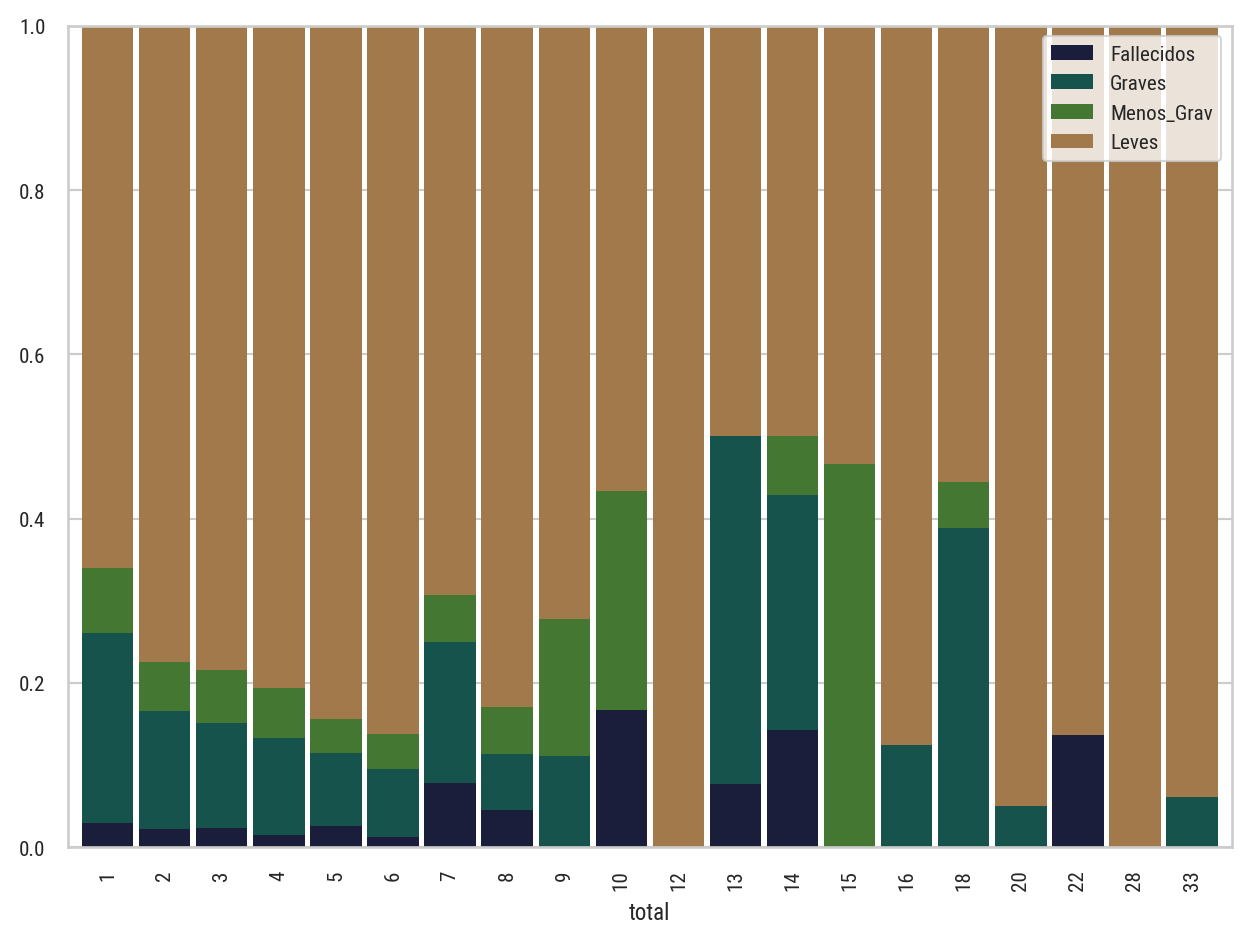

In [165]:
from chiricoca.base.weights import normalize_rows

fig, ax = plt.subplots()

victimas.pipe(normalize_rows).plot(
    kind="bar", stacked=True, linewidth=0, width=0.9, ax=ax
)

ax.set_ylim([0,1])

## ¿Cuándo?

<Axes: xlabel='Fecha'>

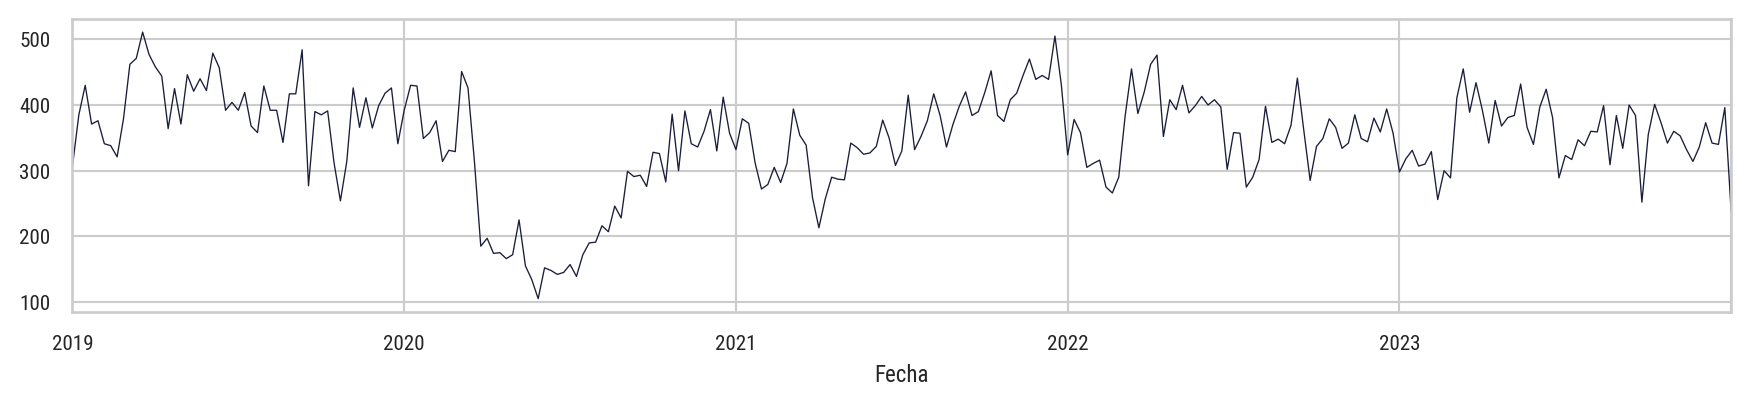

In [170]:
fig, ax = plt.subplots(figsize=(9, 2))
scl.resample('1W', on='Fecha').size().plot(linewidth=0.5)

In [171]:
scl.groupby(['year', 'day_of_week']).size().unstack().pipe(normalize_rows)

day_of_week         0         1         2         3         4         5  \
year                                                                      
2019         0.153627  0.149804  0.142014  0.145836  0.169013  0.133401   
2020         0.153358  0.147709  0.153358  0.150499  0.165144  0.134598   
2021         0.145449  0.150184  0.149758  0.154652  0.174815  0.125286   
2022         0.141290  0.152737  0.149292  0.149557  0.165987  0.134294   
2023         0.143066  0.151259  0.152452  0.152724  0.161350  0.132921   

day_of_week         6  
year                   
2019         0.106305  
2020         0.095334  
2021         0.099856  
2022         0.106842  
2023         0.106228

<Axes: xlabel='day_of_week', ylabel='year'>

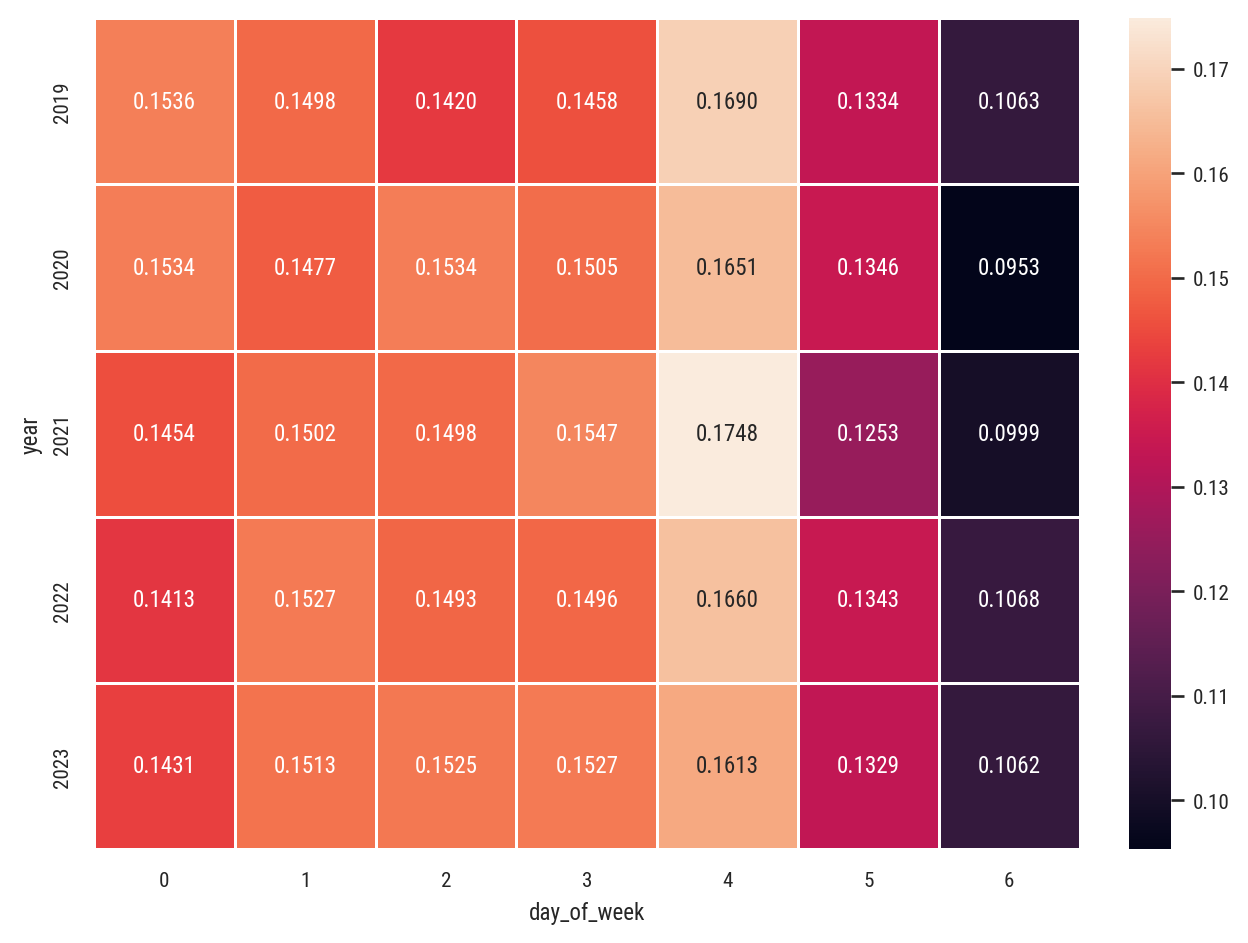

In [173]:
sns.heatmap(scl.groupby(['year', 'day_of_week']).size().unstack().pipe(normalize_rows), annot=True, linewidth=1, fmt='.4f')

## ¿Dónde?

In [175]:
scl['victimas'] = scl[["Fallecidos", "Graves", "Menos_Grav"]].sum(axis=1)

(<matplotlib.contour.QuadContourSet at 0x7fa36fcf0090>, None, <Axes: >)

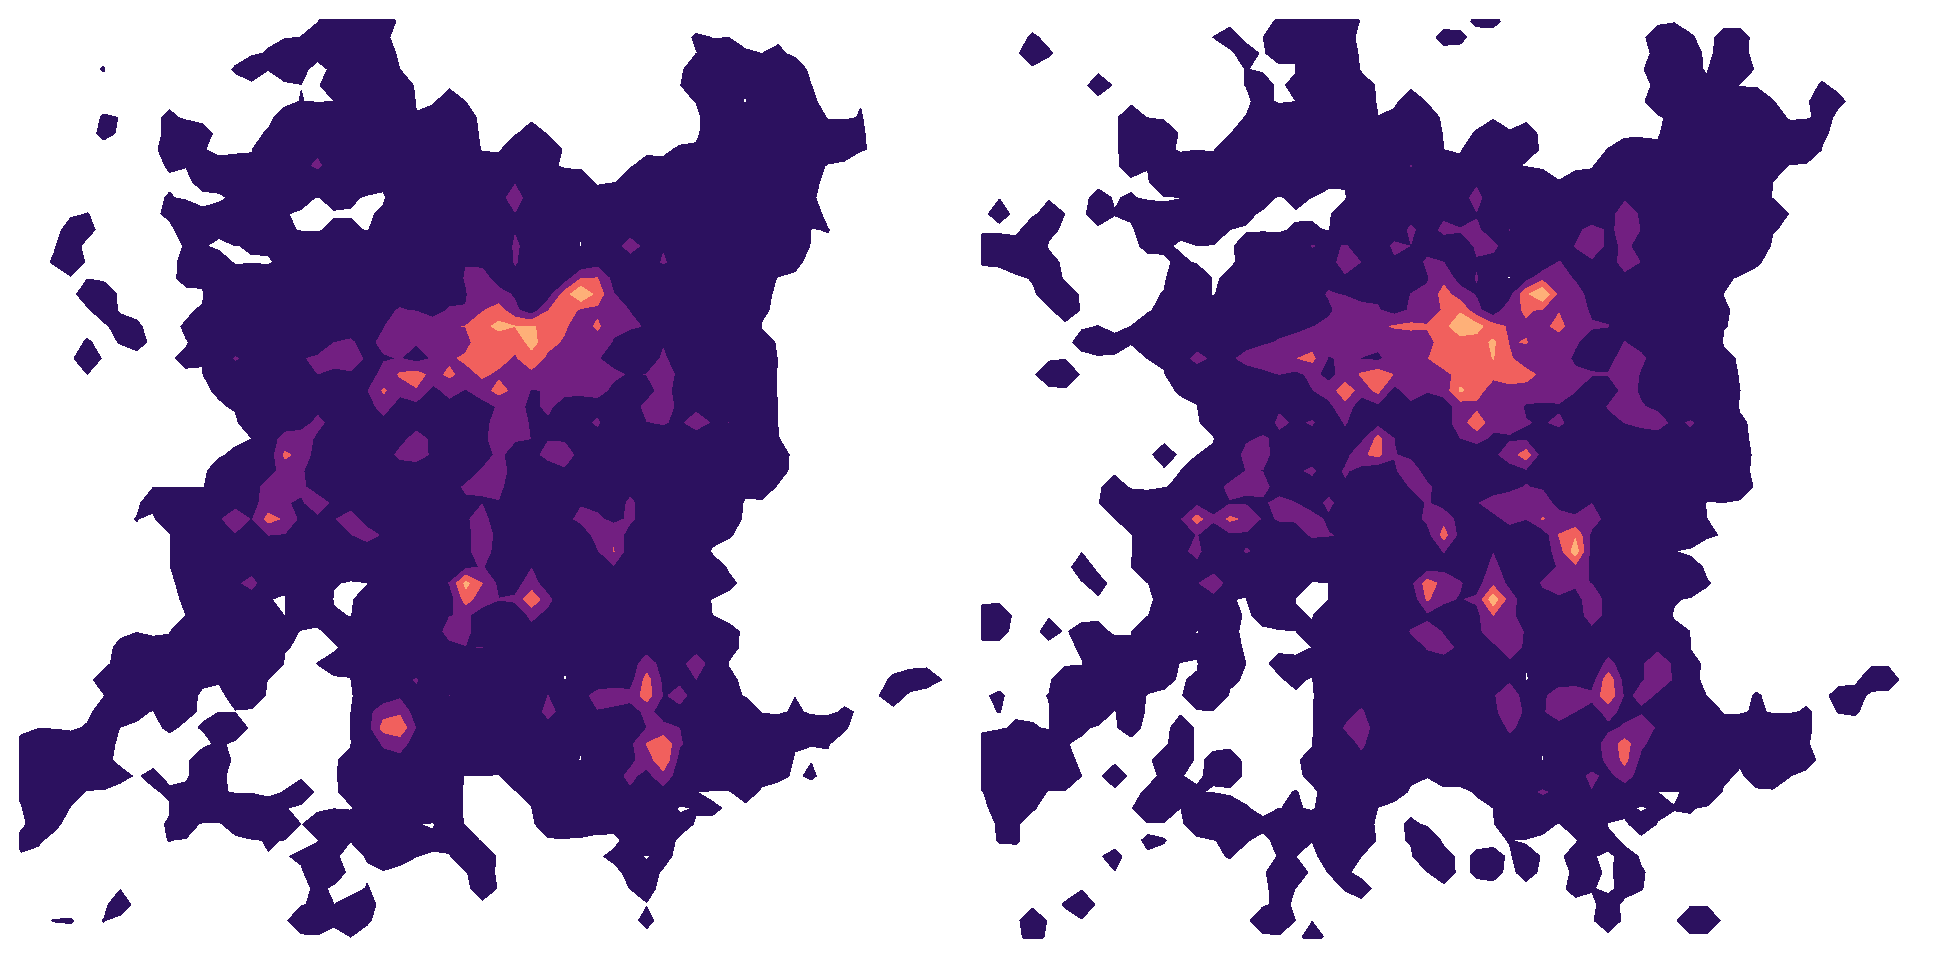

In [177]:
from chiricoca.maps import heat_map
from chiricoca.geo.figures import small_multiples_from_geodataframe

fig, axes = small_multiples_from_geodataframe(scl, 2)

heat_map(scl, bandwidth=0.005, low_threshold=0.005, ax=axes[0])
heat_map(scl, weight="victimas", bandwidth=0.005, low_threshold=0.005, ax=axes[1])

## ¿Cómo?

In [179]:
tipo_por_comuna = (
    scl.groupby(["comuna", "Tipo__CONA"]).size()
    .unstack(fill_value=0)
)

tipo_por_comuna


Tipo__CONA           ATROPELLO  CAIDA  CHOQUE  COLISION  INCENDIO  OTRO TIPO  \
comuna                                                                         
BUIN                         1      0      11        14         0          1   
CALERA DE TANGO             18      4      94       303         0         11   
CERRILLOS                  111     40     781      1289         0         17   
CERRO NAVIA                 63     10     201       558         0         10   
COLINA                       3      1      21        45         0          2   
CONCHALI                    97     15     330       857         0         13   
CURACAVI                     1      0       0         1         0          0   
EL BOSQUE                  193     30     733      1150         0         13   
EL MONTE                     1      0       0         0         0          0   
ESTACION CENTRAL           284     40     390      1749         0         65   
HUECHURABA                 122     12     283       820         0         17   
INDEPENDENCIA              162     31     233      1205         0          7   
LA CISTERNA                148     19     716      1681         5         77   
LA FLORIDA                 299     45     448      2101         0         34   
LA GRANJA                   88     15     271       884         0          4   
LA PINTANA                 183     14     472      1189         0          8   
LA REINA                    76     20     314       788         0         89   
LAMPA                        4      0      57       100         0          1   
LAS CONDES                 237     46     431      2234         0         55   
LO BARNECHEA                73     10     346       499         0         21   
LO ESPEJO                   18      0     147       300         0         15   
LO PRADO                   149     35     452       773         0         12   
MACUL                       94     21     206      1048         0         15   
MAIPU                      562    129    1642      4699         0         85   
MELIPILLA                    1      0       0         0         0          0   
NUNOA                       44      7      84       538         0          1   
PADRE HURTADO               45      4     208       354         1         24   
PAINE                        0      0       0         2         0          0   
PEDRO AGUIRRE CERDA         94      2     282       724         0          7   
PENAFLOR                    16      1      44       138         0          2   
PENALOLEN                   41      3     175       405         0          3   
PEÃ‘ALOLEN                  75     11     137       529         0          5   
PEÑAFLOR                    26      3     109       259         0         10   
PEÑALOLEN                  136     21     406      1214         0          3   
PIRQUE                       7      0      38        78         0          0   
PROVIDENCIA                322     85    1285      3719         1         28   
PUDAHUEL                   185     32     436      1729         0         18   
PUENTE ALTO                655    156    2265      4361         0        163   
QUILICURA                  136     16     313      1334         0         19   
QUINTA NORMA                36     11      80       362         0         13   
QUINTA NORMAL              145     20     378      1198         0         12   
RECOLETA                   220     39     596      1510         2         42   
RENCA                      101     19     307       824         0         16   
SAN BERNARDO               294      7     894      3694         0         42   
SAN JOAQUIN                122     20     241      1267         0          8   
SAN JOSE DE MAIPO            1      0      12         9         0          0   
SAN MIGUEL                  94     20     406      1436         0          6   
SAN RAMON                  109     12     261       803         0         38   


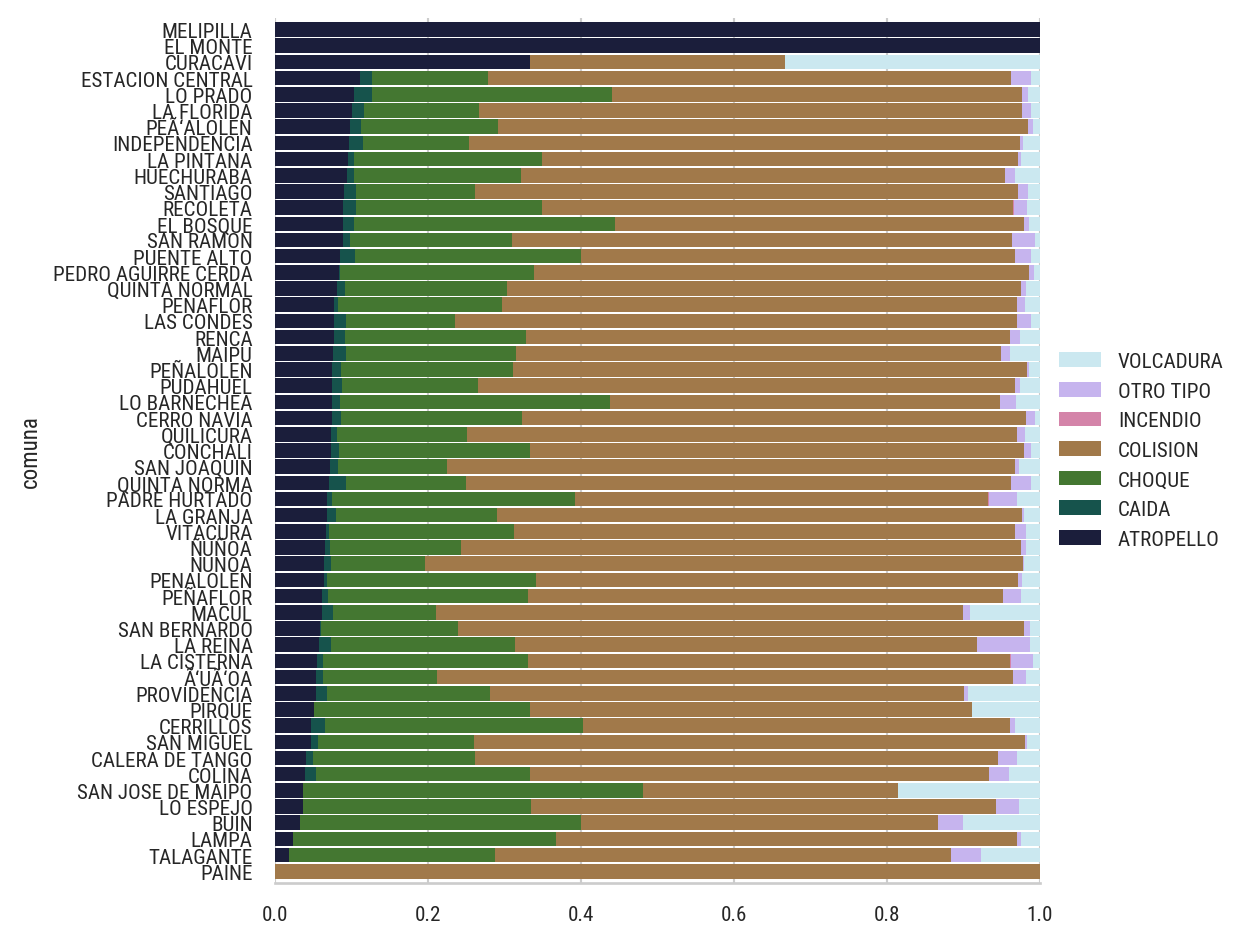

In [182]:
from chiricoca.tables import barchart

barchart(
    tipo_por_comuna,
    stacked=True,
    sort_items=True,
    normalize=True,
    horizontal=True,
    palette="cubehelix"
)

<Axes: xlabel='day_of_week', ylabel='Causa__CON'>

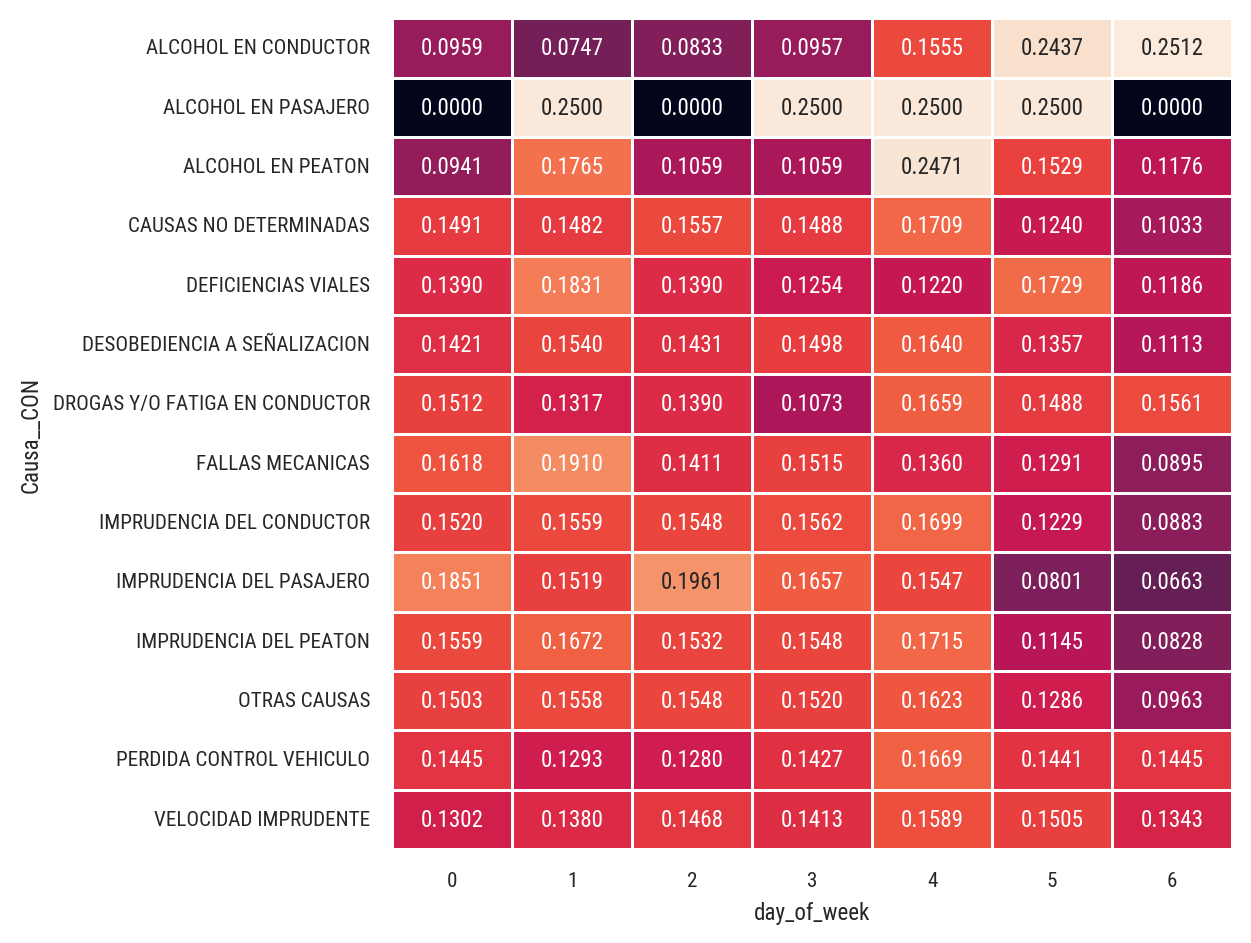

In [189]:
sns.heatmap(
    scl.groupby(["Causa__CON", "day_of_week"])
    .size()
    .unstack(fill_value=0)
    .pipe(normalize_rows), annot=True, fmt='.4f', linewidth=1, cbar=False
)

<Axes: xlabel='month', ylabel='victimas'>

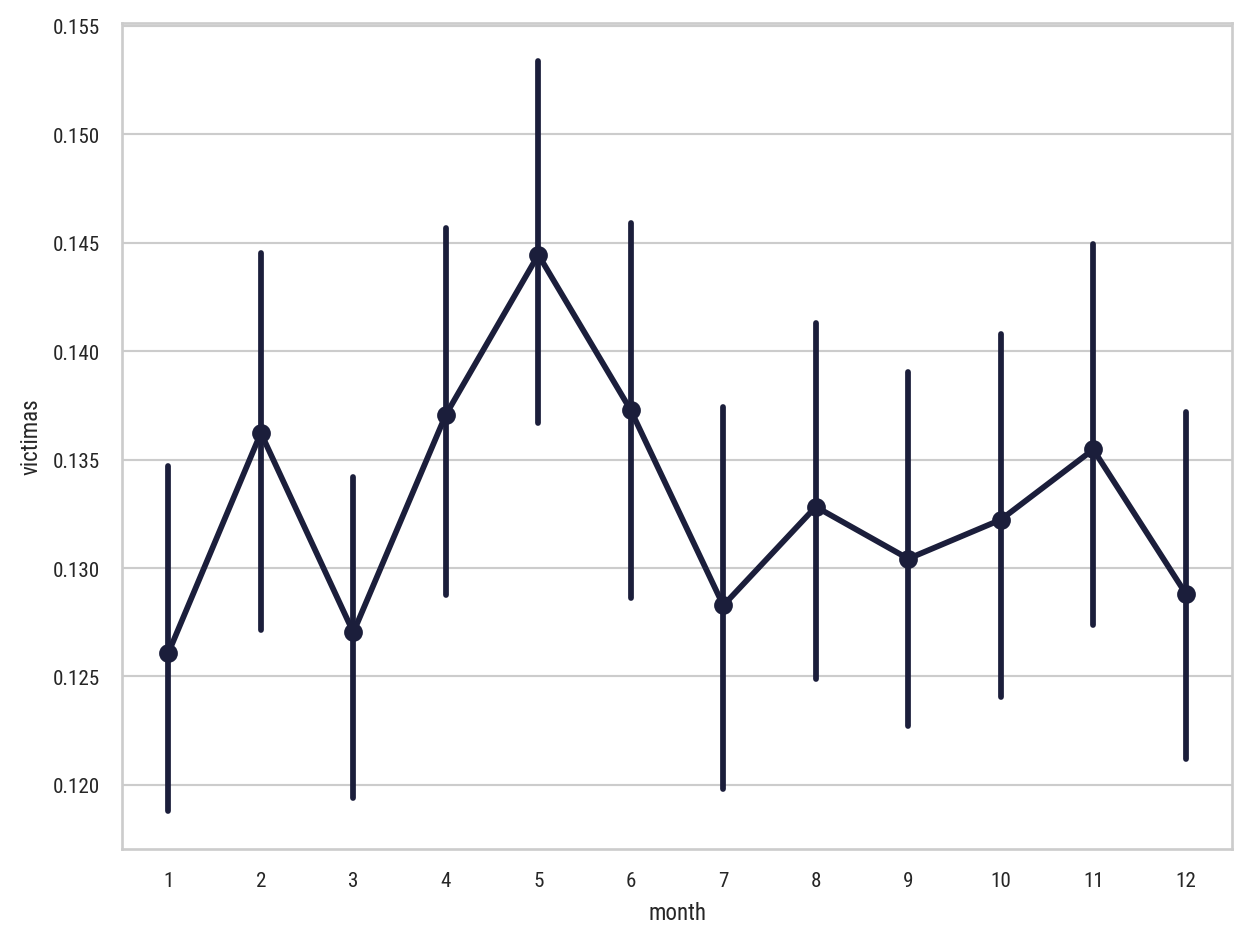

In [190]:
sns.pointplot(scl, x='month', y='victimas')

<Axes: xlabel='month', ylabel='victimas'>

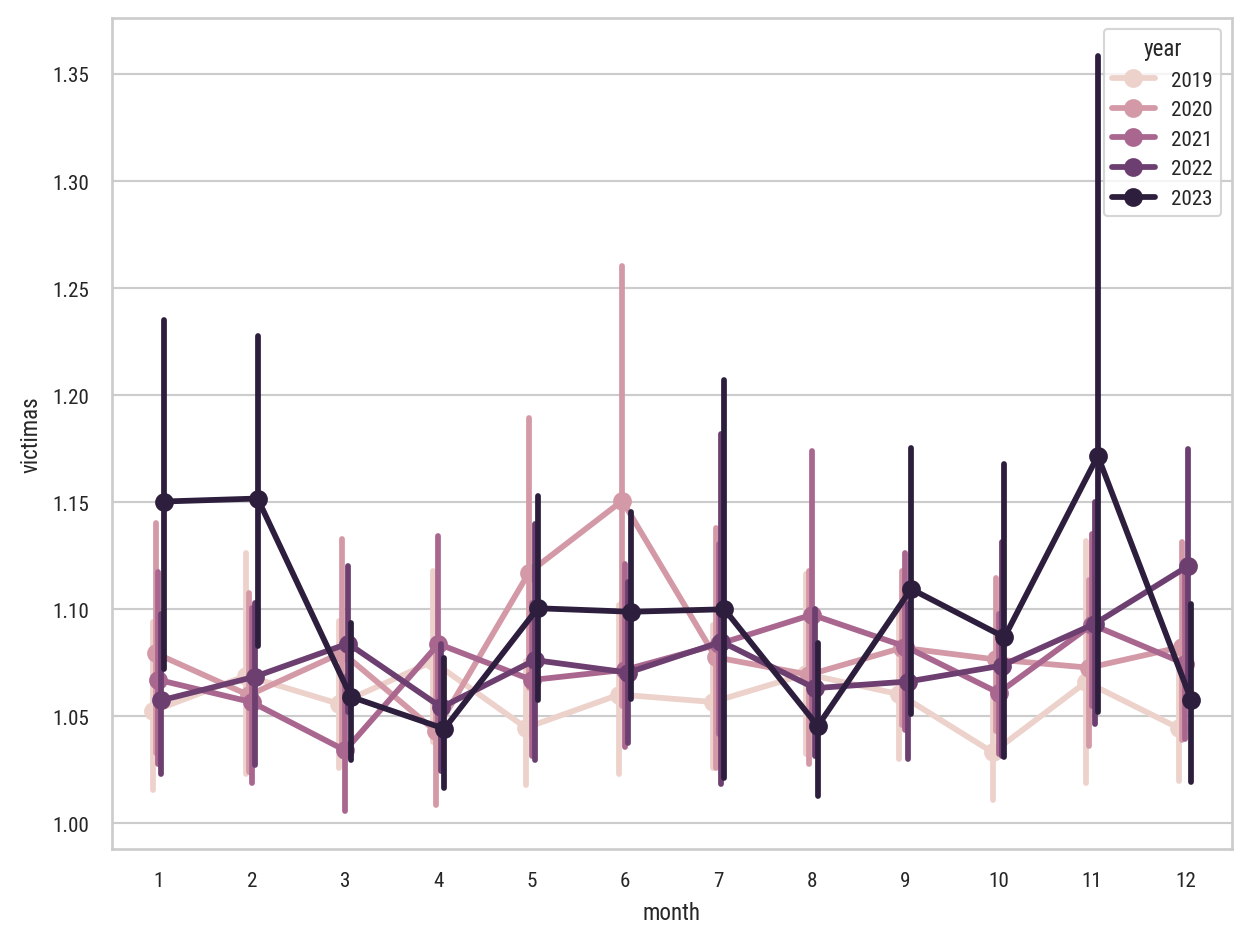

In [193]:
sns.pointplot(scl[scl['victimas'] > 0], x='month', y='victimas', hue='year', dodge=True)

<Axes: ylabel='Causa__CON'>

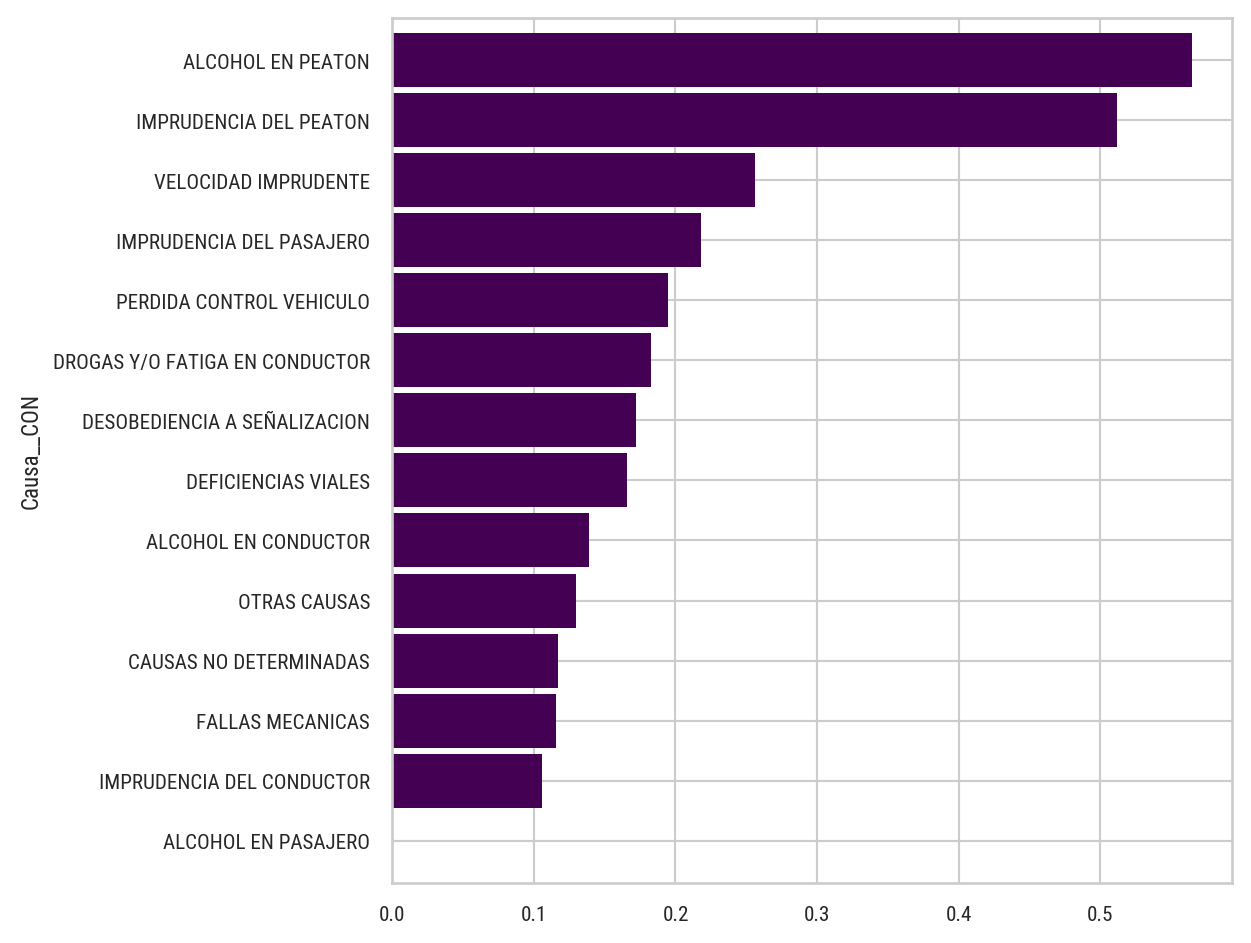

In [196]:
scl.groupby("Causa__CON")["victimas"].mean().sort_values(ascending=True).plot(
     kind="barh", cmap="viridis", linewidth=0, width=0.9
)

In [200]:
#sns.boxplot(scl, x='victimas', y='Causa__CON')

/tmp/ipykernel_32578/692017442.py:22: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


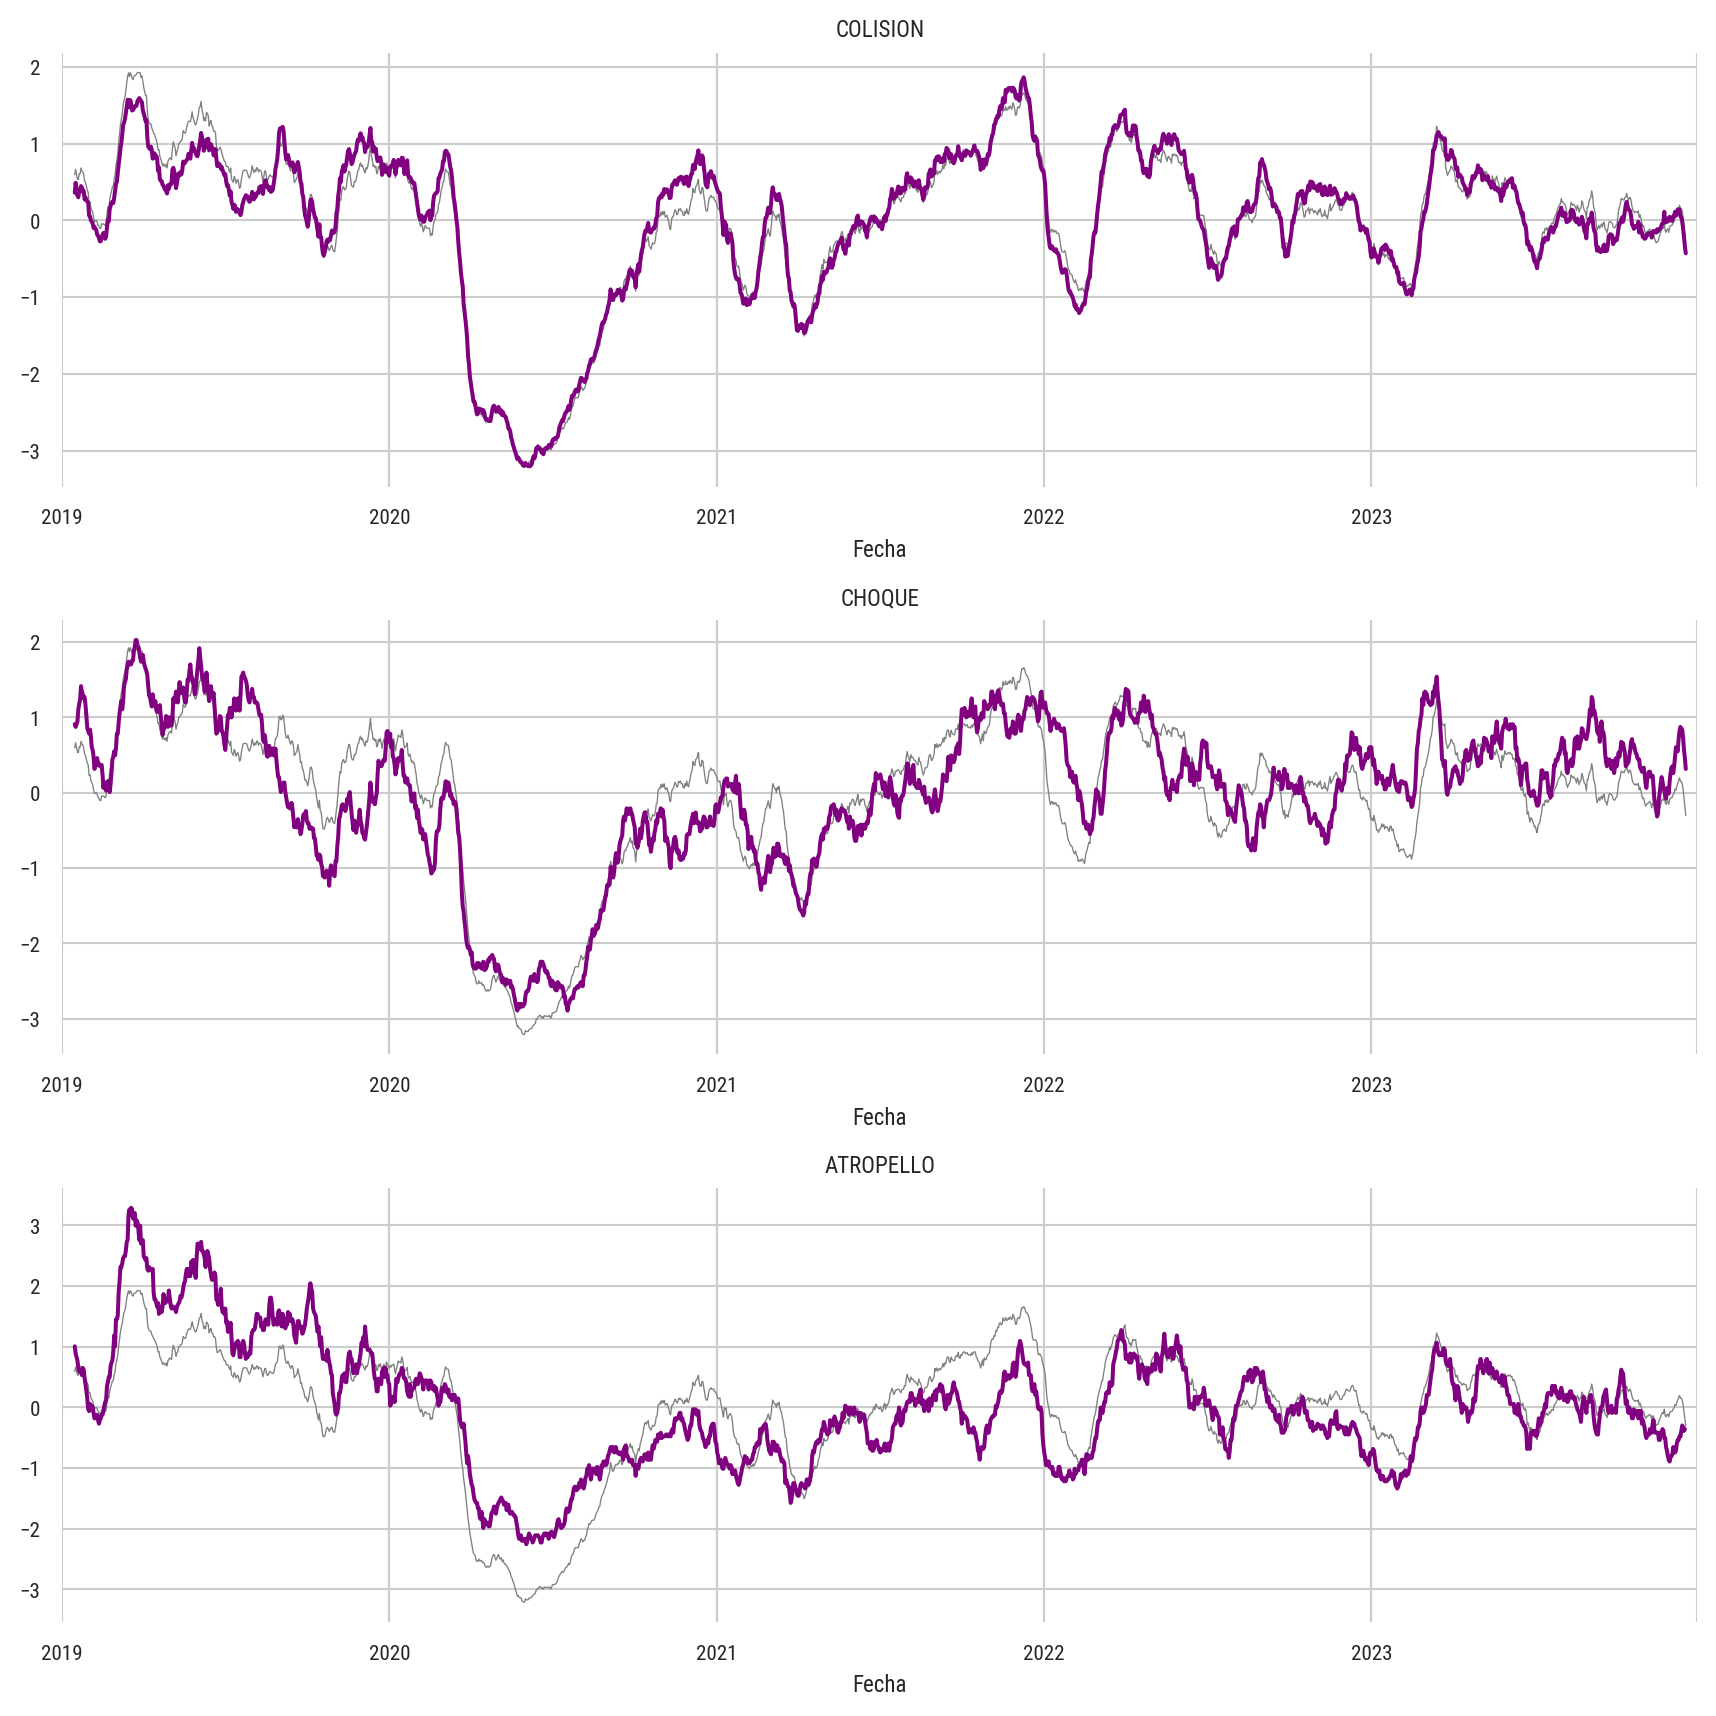

In [204]:
fig, axes = plt.subplots(3, 1, figsize=(9, 9))

mean_accidents = (
    lambda name, x: x.resample("1d", on="Fecha")
    .size()
    # ["victimas"].sum()
    .rolling(28, center=True)
    .mean()
    .rename(name)
    .to_frame()
    .apply(lambda x: (x - x.mean()) / x.std())
)

for ax, cat in zip(axes, ["COLISION", "CHOQUE", "ATROPELLO"]):
    # print(g)
    g = scl[scl["Tipo__CONA"] == cat]
    mean_accidents("all", scl).plot(ax=ax, color="grey", linewidth=0.5, legend=False)
    mean_accidents(cat, g).plot(ax=ax, linewidth=1.5, color="purple", legend=False)
    ax.set_title(cat)
    sns.despine(ax=ax, left=True, bottom=True)

fig.tight_layout()

# Entonces...

¿Es **factible** hacer algo con estos datos? Sí, aunque pareciera que se debe hacer algo a nivel general. La granularidad espacial es buena, pero temporalmente hay inconsistencias graves. Espacialmente también. Además hay pocos meta-datos de los accidentes relacionados con las condiciones en las que sucedieron, por ej., no se incluye el vehículo o las características de las personas.

Quizás lo que más llama la atención es la variación en la proporción de accidentes por día de semana. Ya que tenemos variabilidad espacial y en la proporción de accidentes por día de semana (o bien semana y fin de semana), podríamos iterar nuestro proyecto para que el objetivo sea aportar evidencia para:

1. Desarrollar estrategias de reducción de imprudencia de conductores. La tarea a resolver es **encontrar la relación** entre ubicación, accidentes e infraestructura del lugar. Posiblemente se requieran datos adicionales sobre el entorno construido;
2. Intensificar controles de alcoholemia los fines de semana. La tarea a resolver es **identificar** puntos críticos de accidentes en tipos de días específicos.
   
¡En estos casos, el proyecto parece factible!

¿Propones otros análisis futuros?